In [1]:

import os
# set CUDA_VISIBLE_DEVICES=3
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import torch
import json
from vllm import LLM, SamplingParams
from transformers import AutoTokenizer
from peft import PeftModel

from config_loader import load_config, set_config
from data_processing import load_data, format_data_for_inference
from evaluate import evaluate_predictions, evaluate_predictions_stability
import re

INFO 05-15 05:05:44 [__init__.py:239] Automatically detected platform cuda.


In [2]:
# set the task config
config = load_config("/home/mkeoliya/projects/arpa-h/llm/tasks/mimic_icu/configs/qwen32b_inf.py")
set_config(config)

In [3]:
print("Warning: the result dir will be ", config.RESULTS_DIR)

In [4]:
base_model_id = config.BASE_MODEL_ID
adapter_path = None
LIMIT_X = 100
finetune_duration = 0
inference_duration = 0
stability = True

In [5]:
import logging
def setup_logging():
    """Sets up logging to file and console."""
    logging.basicConfig(
        level=getattr(logging, config.LOGGING_LEVEL.upper()),
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler(config.LOG_FILE),
            logging.StreamHandler()
        ]
    )
setup_logging()


In [6]:
"""Runs inference on the test data using vLLM."""
model_to_load = adapter_path if adapter_path and os.path.exists(adapter_path) else base_model_id
print(f"Starting inference process using model: {model_to_load}")

# Load tokenizer: Use adapter path if available, otherwise use the base model id
tokenizer_path = adapter_path if adapter_path and os.path.exists(adapter_path) else base_model_id
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token # Ensure pad token is set

Starting inference process using model: Qwen/Qwen3-32B


In [7]:
# Initialize vLLM
# vLLM can load PEFT adapters directly or load a merged model.
# Loading the adapter with the base model is generally preferred.
print(f"Initializing vLLM with base model {base_model_id}" # String part 1
        f"{' and adapter ' + adapter_path if adapter_path and os.path.exists(adapter_path) else ''}" # Conditional part 2 using f-string
        )

if adapter_path and os.path.exists(adapter_path):
    llm = LLM(
        model=base_model_id,
        peft_adapter=adapter_path, # Point vLLM to the PEFT adapter directory
        tokenizer=tokenizer_path, # Use the tokenizer saved with the adapter
        tensor_parallel_size=config.VLLM_TENSOR_PARALLEL_SIZE,
        max_model_len=config.VLLM_MAX_MODEL_LEN,
        dtype=config.VLLM_DTYPE,
    )
else:
    # If no adapter path is provided, load the base model directly
    # This is useful for testing the base model without any finetuning
    print("No adapter path provided. Loading base model directly.")
    # Note: vLLM does not support loading PEFT models directly, so we need to load the base model
    # and then apply the adapter weights manually if needed.
    llm = LLM(
        model=base_model_id,
        tokenizer=tokenizer_path, # Use the tokenizer saved with the adapter
        tensor_parallel_size=config.VLLM_TENSOR_PARALLEL_SIZE,
        max_model_len=config.VLLM_MAX_MODEL_LEN,
        dtype=config.VLLM_DTYPE,
    )
print("vLLM initialized.")

Initializing vLLM with base model Qwen/Qwen3-32B
No adapter path provided. Loading base model directly.
INFO 05-15 05:05:59 [config.py:689] This model supports multiple tasks: {'classify', 'generate', 'reward', 'embed', 'score'}. Defaulting to 'generate'.
INFO 05-15 05:06:00 [config.py:1901] Chunked prefill is enabled with max_num_batched_tokens=8192.
INFO 05-15 05:06:02 [core.py:61] Initializing a V1 LLM engine (v0.8.4) with config: model='Qwen/Qwen3-32B', speculative_config=None, tokenizer='Qwen/Qwen3-32B', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=4000, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='auto', reasoning_backend=None), ob

Loading safetensors checkpoint shards:   0% Completed | 0/17 [00:00<?, ?it/s]


INFO 05-15 05:06:26 [loader.py:458] Loading weights took 14.77 seconds
INFO 05-15 05:06:27 [gpu_model_runner.py:1291] Model loading took 61.0347 GiB and 15.607623 seconds
INFO 05-15 05:06:46 [backends.py:416] Using cache directory: /home/mkeoliya/.cache/vllm/torch_compile_cache/7a1ce5a524/rank_0_0 for vLLM's torch.compile
INFO 05-15 05:06:46 [backends.py:426] Dynamo bytecode transform time: 19.43 s
INFO 05-15 05:06:52 [backends.py:115] Directly load the compiled graph for shape None from the cache
INFO 05-15 05:07:12 [monitor.py:33] torch.compile takes 19.43 s in total
INFO 05-15 05:07:17 [kv_cache_utils.py:634] GPU KV cache size: 33,024 tokens
INFO 05-15 05:07:17 [kv_cache_utils.py:637] Maximum concurrency for 4,000 tokens per request: 8.26x
INFO 05-15 05:09:02 [gpu_model_runner.py:1626] Graph capturing finished in 105 secs, took 1.04 GiB
INFO 05-15 05:09:02 [core.py:163] init engine (profile, create kv cache, warmup model) took 155.35 seconds
INFO 05-15 05:09:02 [core_client.py:435] 

In [8]:
config.CSN_COLUMN = 'stay_id'
config.PROMPT_TEMPLATE_FILE

'/home/mkeoliya/projects/arpa-h/llm/tasks/mimic_icu/prompts/prompt_template.txt'

In [9]:
# Load and format test data
print("Loading and formatting test data for inference...")
test_df = load_data(config.TEST_FILE)

# keep just the first X rows
test_df = test_df.head(LIMIT_X) # Uncomment for testing with a smaller subset
test_prompts = format_data_for_inference(test_df, config.PROMPT_TEMPLATE_FILE, tokenizer)
true_labels = test_df[config.LABEL_COLUMN].tolist()
csns = test_df[config.CSN_COLUMN].tolist()
# times = test_df[config.TIMEUPTO_COLUMN].tolist()
print(f"Prepared {len(test_prompts)} prompts for inference.")

# Configure sampling parameters
sampling_params = SamplingParams(
    temperature=config.VLLM_TEMPERATURE,
    top_p=config.VLLM_TOP_P,
    top_k=config.VLLM_TOP_K,
    min_p=config.VLLM_MIN_P,
    presence_penalty=config.VLLM_PRESENCE_PENALTY,
    max_tokens=config.VLLM_MAX_TOKENS,
    stop=config.VLLM_STOP_SEQUENCES,
    # Add logprobs=1 to potentially get probabilities if needed for analysis,
    # but not required for simple prediction extraction.
    # logprobs=1,
)
print("Sampling parameters configured.")


Loading and formatting test data for inference...
Loading data from /home/mkeoliya/projects/arpa-h/llm/tasks/mimic_icu/data/test.parquet...
Data loaded. Shape: (1939, 3)


2025-05-15 05:09:03,777 - INFO - Median prompt length: 1031 tokens.
2025-05-15 05:09:03,779 - INFO - Max prompt length: 1543 tokens.


Prepared 100 prompts for inference.
Sampling parameters configured.


In [10]:
print(test_prompts[4])

<|im_start|>system
You are a medical AI assistant focused on predicting the need for transfer to the Intensive Care Unit (ICU) for patients currently in a non-ICU setting. Your primary task is to analyze provided Electronic Health Record (EHR) data, to assess the likelihood of a patient requiring transfer to the ICU within the next 6 hours from the last recorded data point.

The input will be a chronologically ordered sequence of patient data from their current hospitalization or visit. Each entry follows the format: <time_stamp>: <data>, where <time_stamp> denotes the relative time in hours. The data will include patient demographics, medical history, current medications, and vital signs.


Pay close attention to trends and critical factors in the following parameters, as they relate to the risk of requiring a higher level of care in the ICU:

- Vital Signs & Physiological Parameters: New or worsening instability in vital signs (hypotension, significant or symptomatic tachycardia/brad

In [11]:
# Run inference
print("Running inference with vLLM...")
print("number of prompts:", len(test_prompts))
outputs = llm.generate(test_prompts, sampling_params)
print("Inference finished.")

# Process outputs and extract predictions
predicted_labels = []
extracted_texts = []
predicted_probs = []
print("Processing vLLM outputs...")
for output in outputs:
    generated_text = output.outputs[0].text.strip()
    extracted_texts.append(generated_text)

    # Simple parsing logic: Look for "Prediction: Yes" or "Prediction: No"
    # Make this case-insensitive and robust
    prediction = False # Default to predicting False (No sepsis)
    if "Prediction: Yes" in generated_text or "Yes" in generated_text:
        prediction = True
    # If both "Yes" and "No" appear, the *first* one is likely the intended prediction.
    # This simple check assumes "Yes" appearing anywhere means Yes, unless "No" appears *before* it.
    # A more robust regex or sequence check could be implemented.
    # Given the prompt format, the first word after "Prediction:" should be "Yes" or "No".
    # Let's refine the parsing slightly to look right after the tag.
    tag = "Prediction:"
    if tag in generated_text:
        after_tag = generated_text.split(tag, 1)[1].strip().lower()
        if after_tag.startswith("yes"):
                prediction = True
        elif after_tag.startswith("no"):
                prediction = False # Explicitly set to False if No is found first
    
    # Let's extract the probability of the prediction if available, "Risk: 0.95"
    # This is a simple regex to find the confidence score.
    confidence_match = re.search(r"Risk:\s*([0-9]*\.?[0-9]+)", generated_text)
    if confidence_match:
        confidence_score = float(confidence_match.group(1))
        predicted_probs.append(confidence_score)
    else:
        predicted_probs.append(None) # No confidence score found

    predicted_labels.append(prediction)
print("Output processing complete.")

Running inference with vLLM...
number of prompts: 100


Processed prompts:   0%|          | 0/100 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Inference finished.
Processing vLLM outputs...
Output processing complete.


In [16]:
# count number of None in predicted_probs
print("Number of None confidence scores:", predicted_probs.count(None))

Number of None confidence scores: 3


In [17]:
config.RESULTS_DIR

'/home/mkeoliya/projects/arpa-h/llm/tasks/mimic_icu/runs/qwen32b_inf'

In [ ]:
# --- Step 3: Evaluate Results ---
logging.info("--- Evaluation Step ---")
try:
    evaluation_metrics = evaluate_predictions(true_labels, predicted_labels, predicted_probs)
    logging.info("Evaluation completed.")
    logging.info(f"Final Metrics: Precision={evaluation_metrics['precision']:.4f}, Recall={evaluation_metrics['recall']:.4f}, F1={evaluation_metrics['f1_score']:.4f}, AUPRC={evaluation_metrics['auprc']:.4f}, AUROC={evaluation_metrics['auroc']:.4f}")
except Exception as e:
    logging.error(f"Error during evaluation: {e}", exc_info=True)
    logging.critical("Workflow completed with evaluation error.")


# --- Step 4: Log and Save Results ---
results = {
    "finetune_duration_sec": finetune_duration,
    "inference_duration_sec": inference_duration,
    "evaluation_metrics": evaluation_metrics,
    "finetuning_performed": not config.SKIP_FINETUNING,
    "finetune_duration_sec": finetune_duration if not config.SKIP_FINETUNING else "N/A",
    # Optional: Log sample predictions for inspection
    "sample_predictions": [{
        "CSN": csns[i],
        "TrueLabel": true_labels[i],
        "PredictedLabel": predicted_labels[i],
        # "TimeUpto": times[i] if stability else None,
        "TestPrompt": test_prompts[i],
        "ExtractedText": extracted_texts[i]
    } for i in range(min(60, len(csns)))], # Log first 10 samples
    "all_predictions": [{
            "CSN": csns[i],
            "TrueLabel": true_labels[i],
            "PredictedLabel": predicted_labels[i],
            # "TimeUpto": times[i] if stability else None,
            "PredictedProb": predicted_probs[i],
            "TestPromptLength": len(test_prompts[i]),
            "GeneratedTextLength": len(extracted_texts[i]),
        } for i in range(len(csns))] # Log all samples
}

try:
    with open(config.RESULTS_FILE, 'w') as f:
        json.dump(results, f, indent=4)
    logging.info(f"Results saved to {config.RESULTS_FILE}")
except Exception as e:
    logging.error(f"Error saving results file: {e}", exc_info=True)

2025-05-15 05:12:44,466 - INFO - --- Evaluation Step ---


2025-05-15 05:12:44,562 - INFO - Evaluation completed.
2025-05-15 05:12:44,563 - INFO - Final Metrics: Precision=0.3333, Recall=0.5926, F1=0.4267, AUPRC=0.3565, AUROC=0.6353


Starting evaluation...
Evaluation complete.
Results: {'precision': 0.3333333333333333, 'recall': 0.5925925925925926, 'f1_score': 0.4266666666666667, 'auroc': 0.6352777777777778, 'auprc': 0.3565148413181305, 'num_samples': 100, 'num_positive_true': 27, 'num_positive_predicted': 48}


NameError: name 'times' is not defined

In [ ]:
# now, let's group the times and pred_probs by CSN; each CSN should have a list of times and pred_probs
from collections import defaultdict
grouped_results = defaultdict(list)
for i in range(len(csns)):
    grouped_results[csns[i]].append({
        "TimeUpto": times[i],
        "PredictedProb": predicted_probs[i],
        "PredictedLabel": predicted_labels[i],
        "TrueLabel": true_labels[i],
        "TestPromptLength": len(test_prompts[i]),
        "GeneratedTextLength": len(extracted_texts[i]),
    })


In [ ]:
# filter out CSNs with < 3 entries
filtered_grouped_results = {csn: entries for csn, entries in grouped_results.items() if len(entries) >= 3}

CSN: 98818359, Lipschitz Constant: 6.0000
Max times for Lipschitz constant: 52.0 54.0


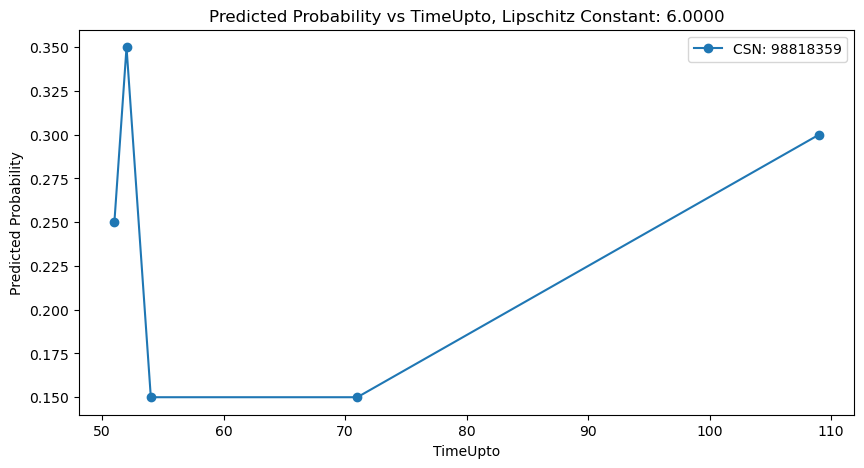

CSN: 98819977, Lipschitz Constant: 6.7500
Max times for Lipschitz constant: 105.0 109.0


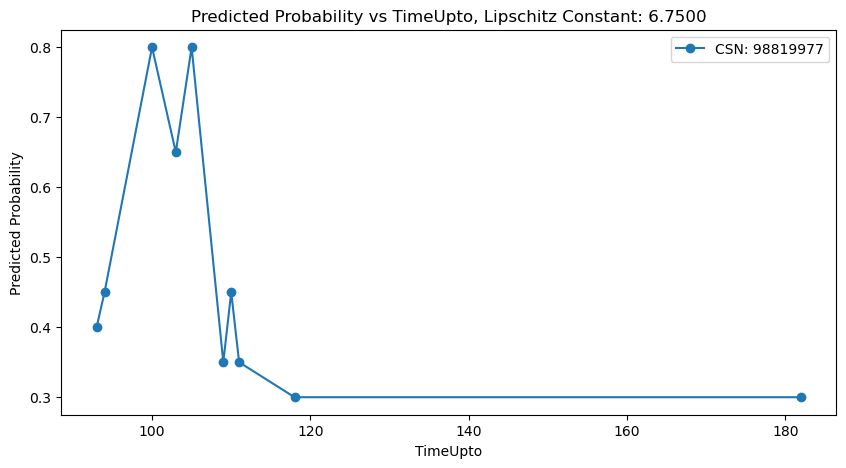

CSN: 98822451, Lipschitz Constant: 2.0000
Max times for Lipschitz constant: 35.0 38.0


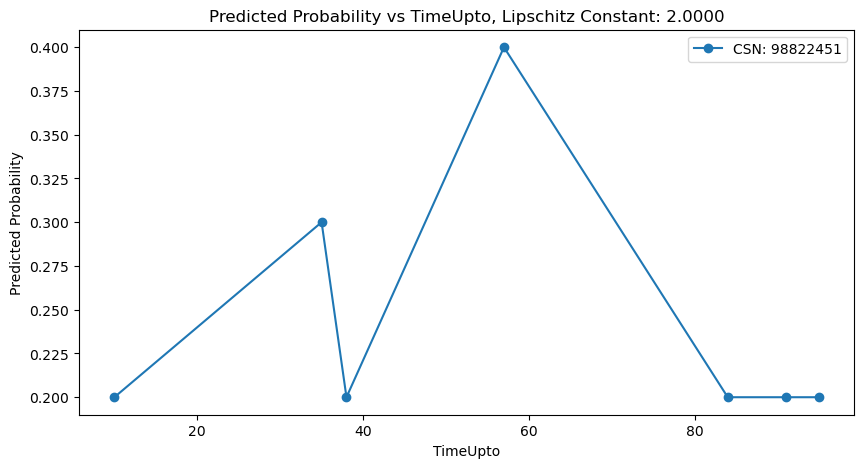

CSN: 98824002, Lipschitz Constant: 0.9231
Max times for Lipschitz constant: 57.0 83.0


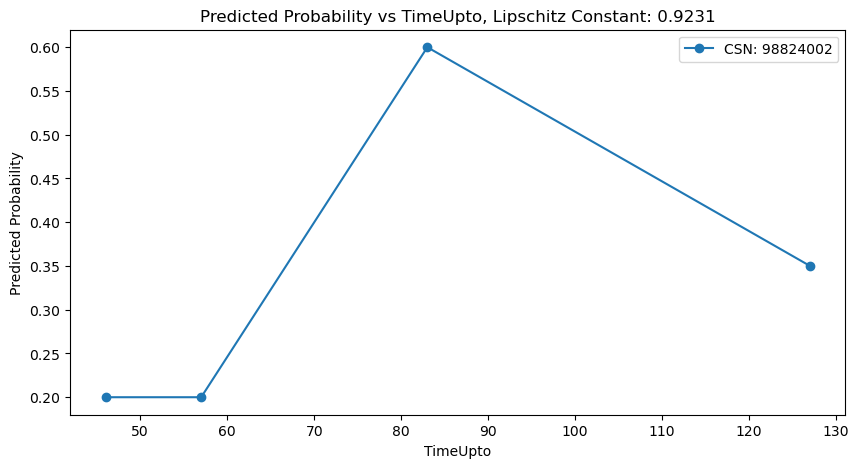

CSN: 98827632, Lipschitz Constant: 0.0000
Max times for Lipschitz constant: 74.0 104.0


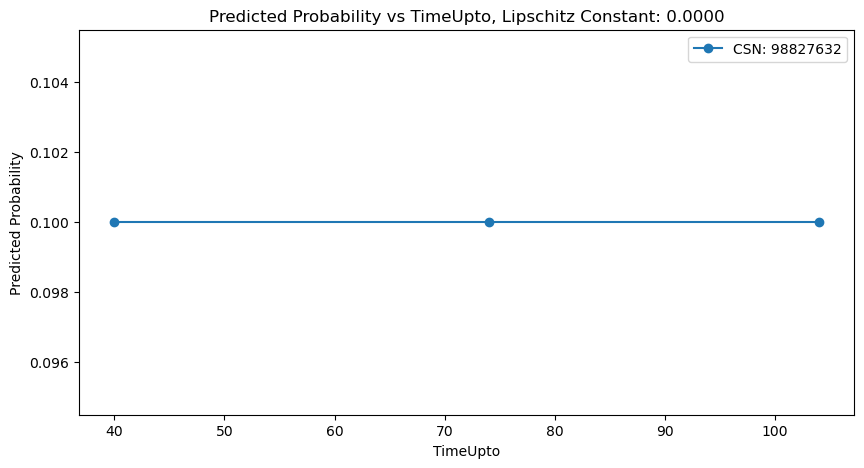

CSN: 98831524, Lipschitz Constant: 0.6000
Max times for Lipschitz constant: 90.0 95.0


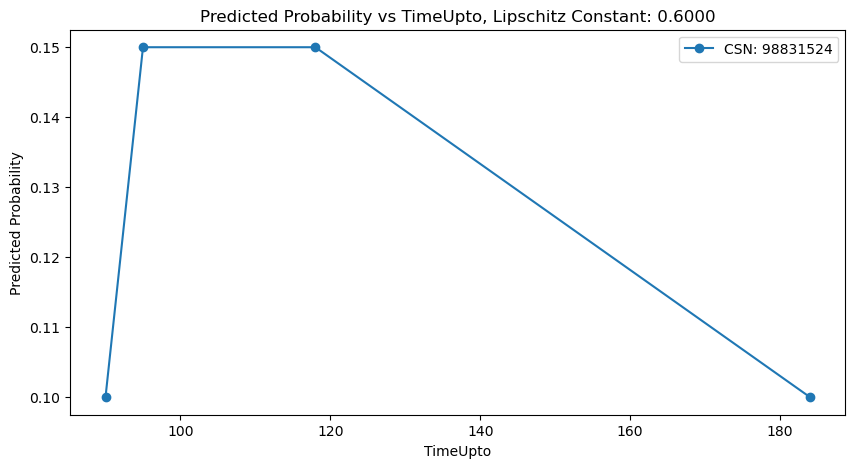

CSN: 98834301, Lipschitz Constant: 6.0000
Max times for Lipschitz constant: 111.0 112.0


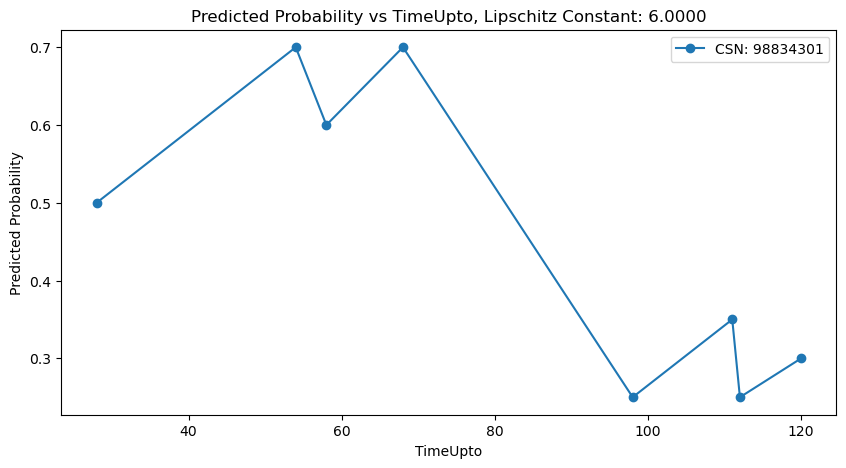

CSN: 98839281, Lipschitz Constant: 27.0000
Max times for Lipschitz constant: 98.0 99.0


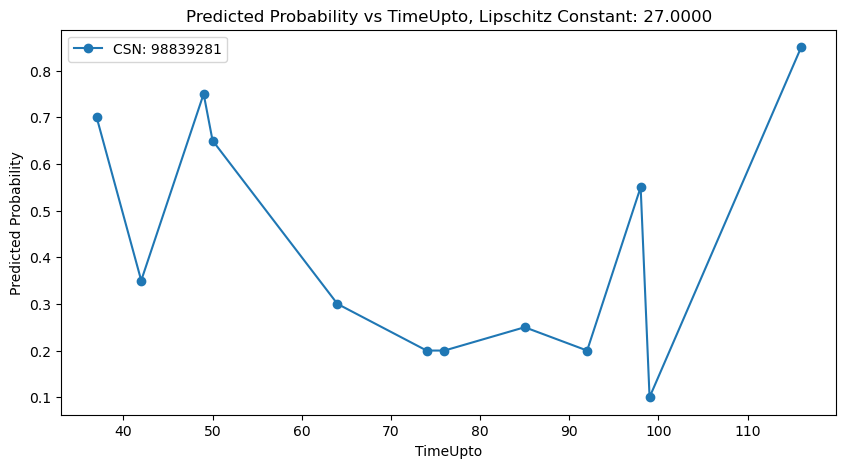

CSN: 98842231, Lipschitz Constant: 3.0000
Max times for Lipschitz constant: 200.0 210.0


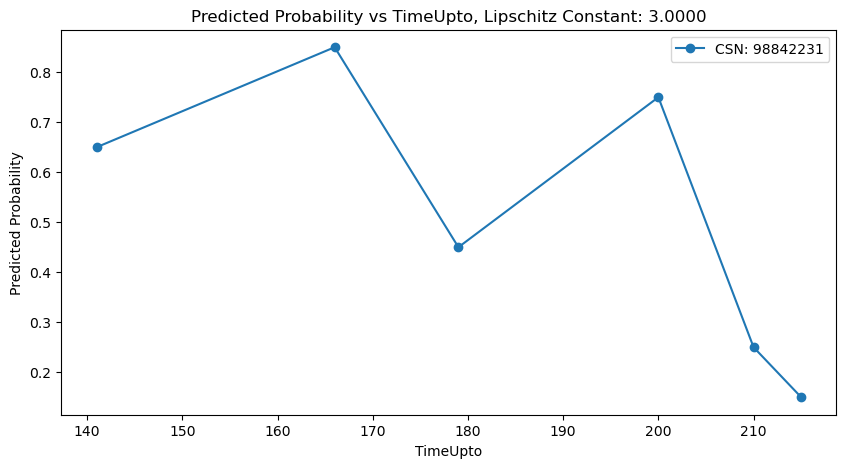

CSN: 98844326, Lipschitz Constant: 7.5000
Max times for Lipschitz constant: 234.0 236.0


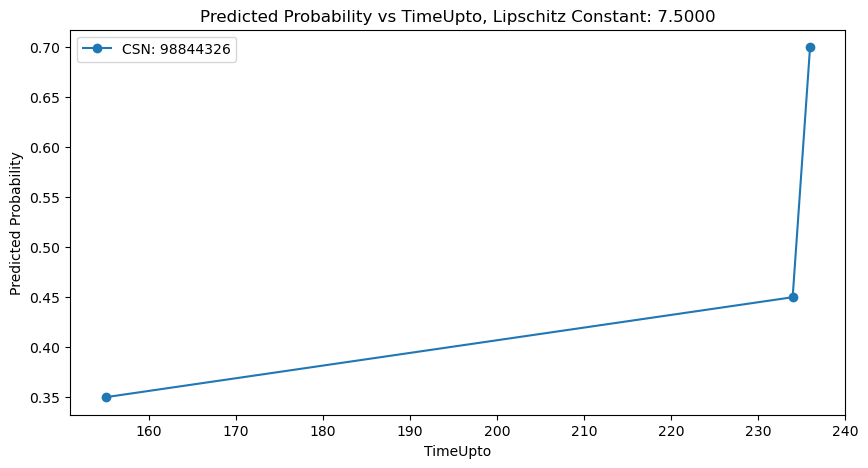

CSN: 98846505, Lipschitz Constant: 33.0000
Max times for Lipschitz constant: 85.0 86.0


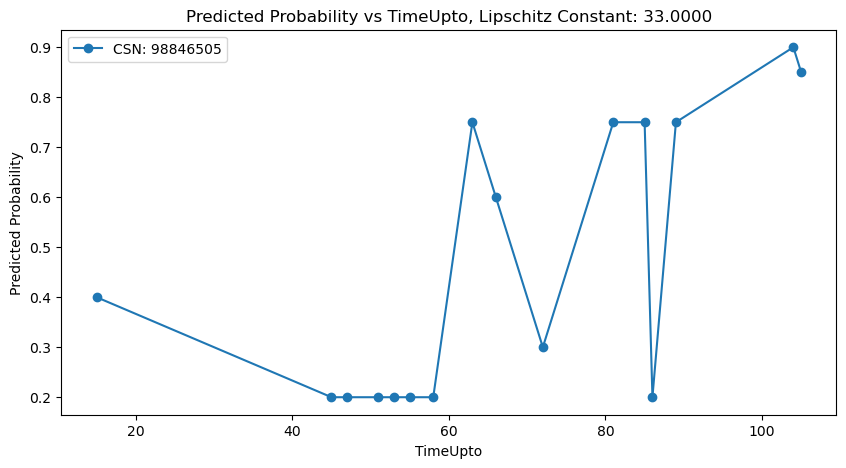

CSN: 98851684, Lipschitz Constant: 6.0000
Max times for Lipschitz constant: 192.0 193.0


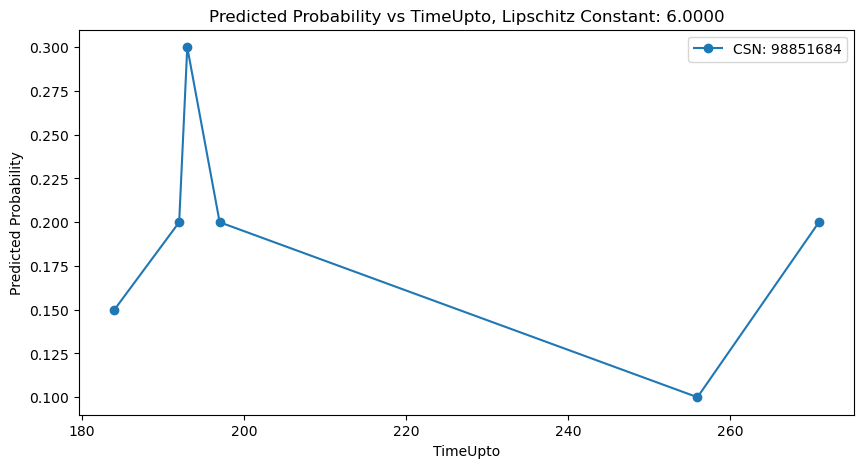

CSN: 98853500, Lipschitz Constant: 5.0000
Max times for Lipschitz constant: 30.0 33.0


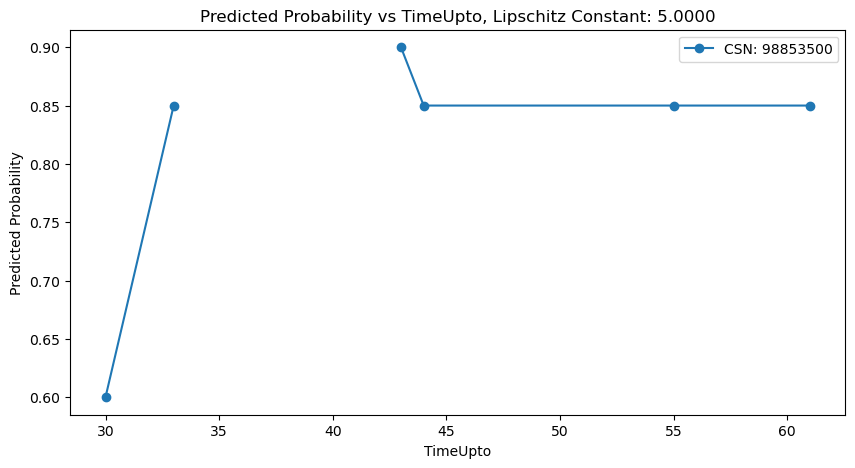

CSN: 98863668, Lipschitz Constant: 0.0000
Max times for Lipschitz constant: 175.0 181.0


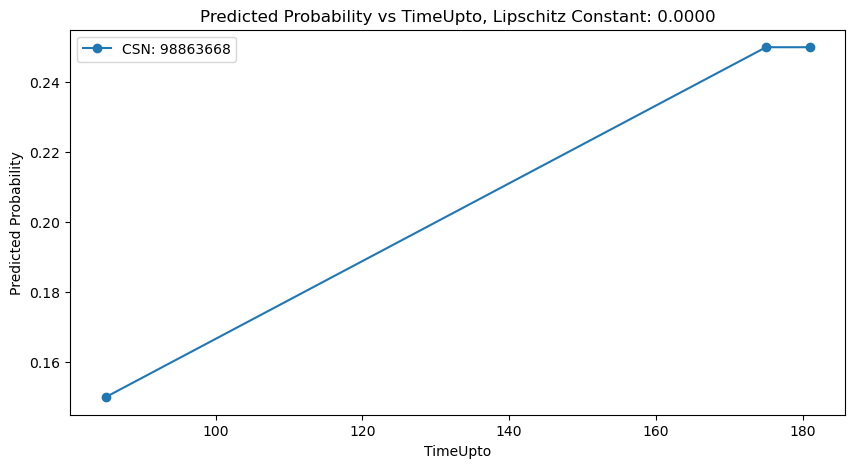

CSN: 98864420, Lipschitz Constant: 6.0000
Max times for Lipschitz constant: 64.0 65.0


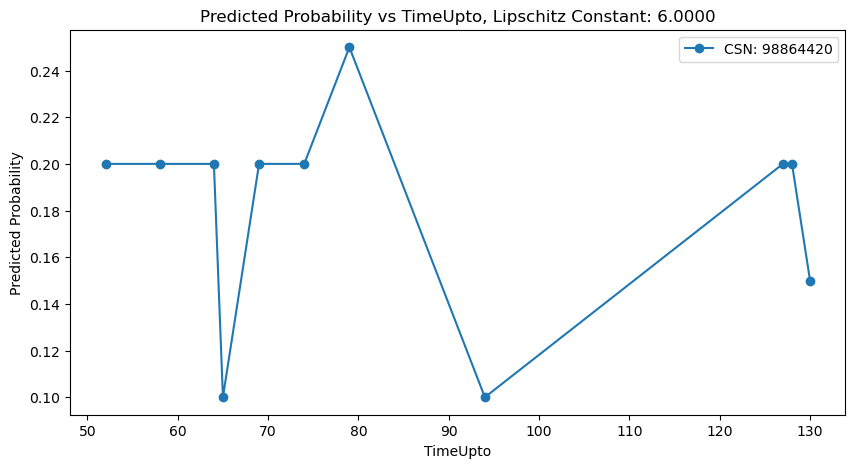

CSN: 98864527, Lipschitz Constant: 3.4286
Max times for Lipschitz constant: 90.0 97.0


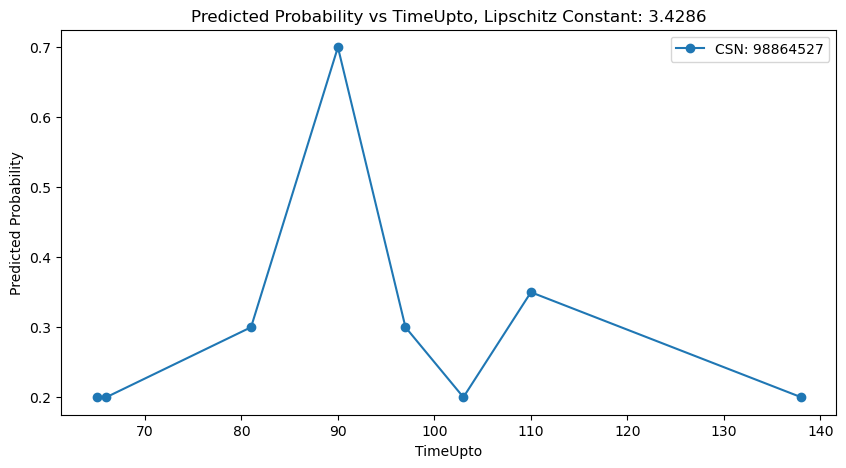

CSN: 98865852, Lipschitz Constant: 6.0000
Max times for Lipschitz constant: 96.0 98.0


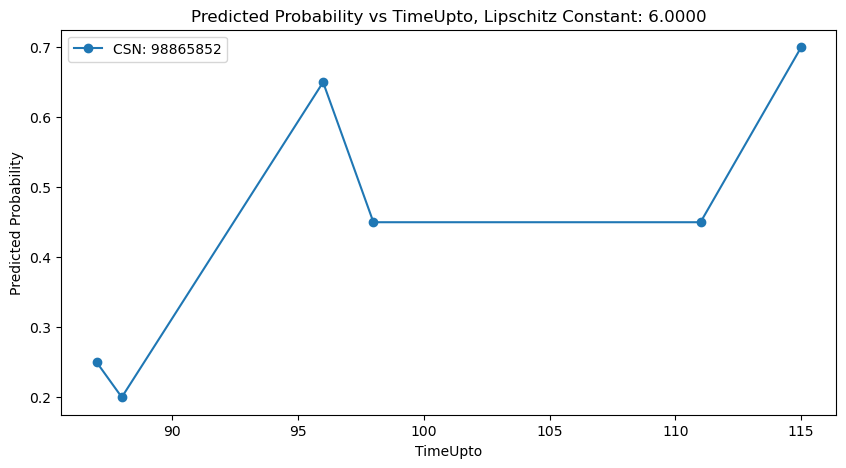

CSN: 98868096, Lipschitz Constant: 0.2727
Max times for Lipschitz constant: 81.0 92.0


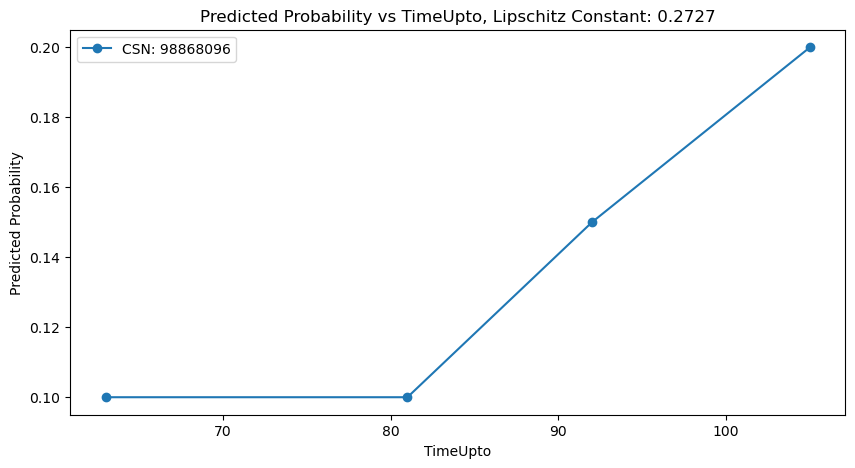

CSN: 98869597, Lipschitz Constant: 24.0000
Max times for Lipschitz constant: 69.0 70.0


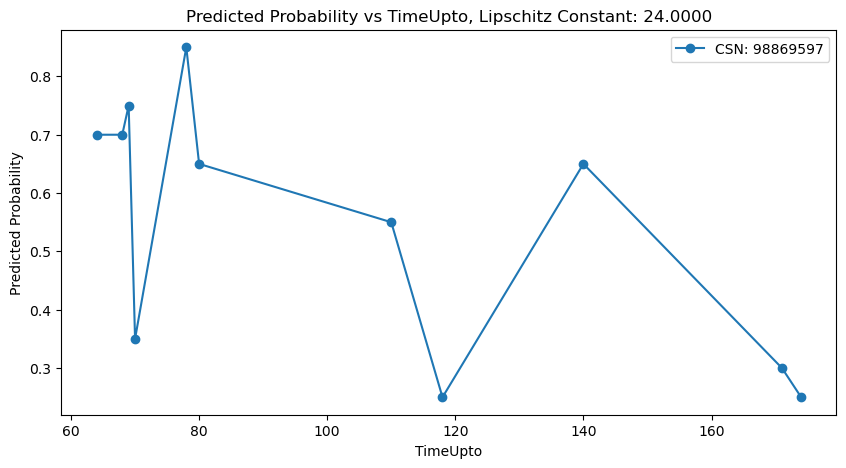

CSN: 98869832, Lipschitz Constant: 0.3000
Max times for Lipschitz constant: 323.0 327.0


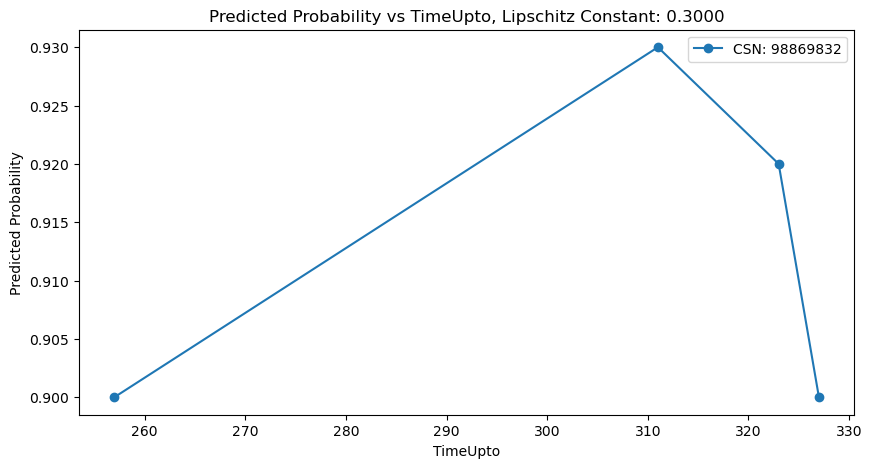

CSN: 98870716, Lipschitz Constant: 18.0000
Max times for Lipschitz constant: 433.0 434.0


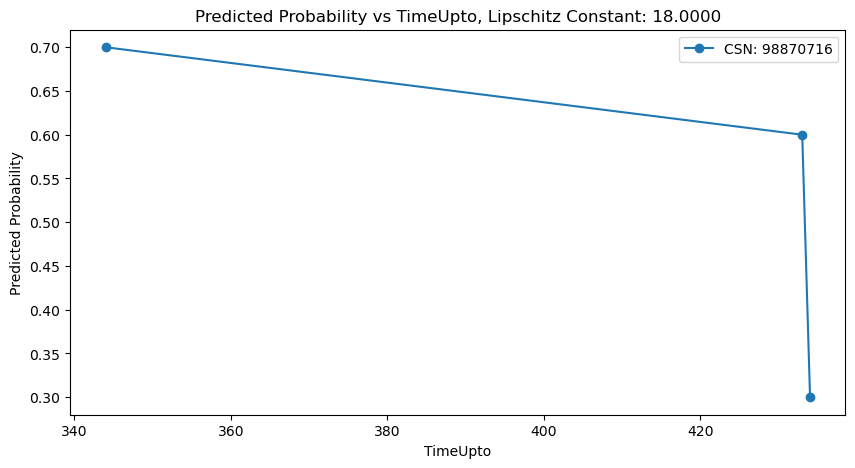

CSN: 98871257, Lipschitz Constant: 0.0000
Max times for Lipschitz constant: 148.0 188.0


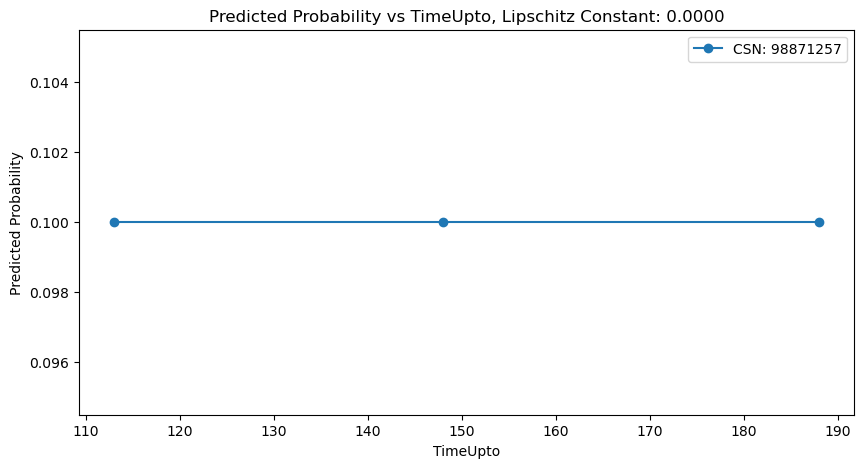

CSN: 98874129, Lipschitz Constant: 0.2727
Max times for Lipschitz constant: 69.0 80.0


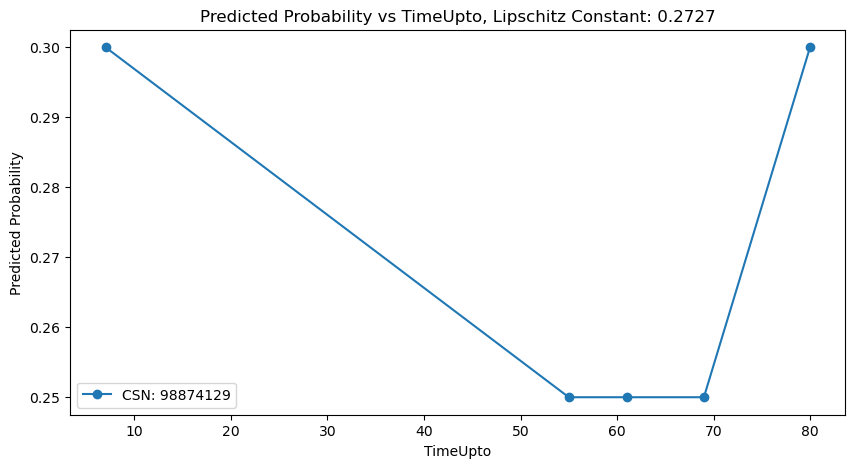

CSN: 98877815, Lipschitz Constant: 6.0000
Max times for Lipschitz constant: 376.0 377.0


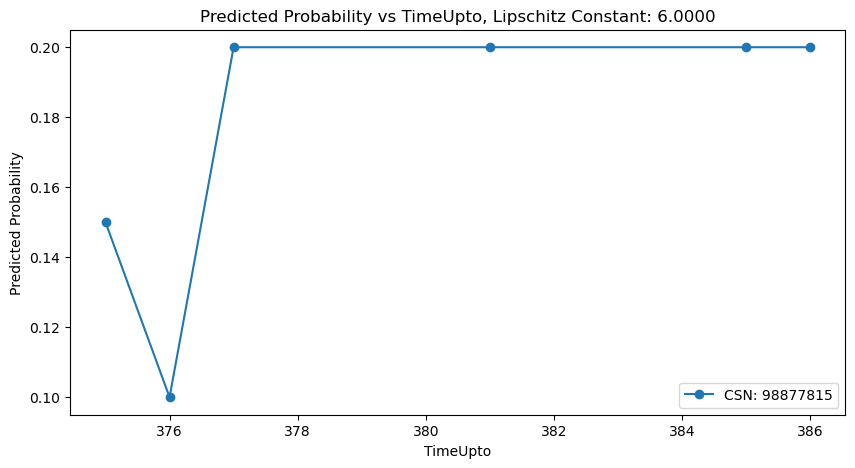

CSN: 98879382, Lipschitz Constant: 0.1429
Max times for Lipschitz constant: 215.0 236.0


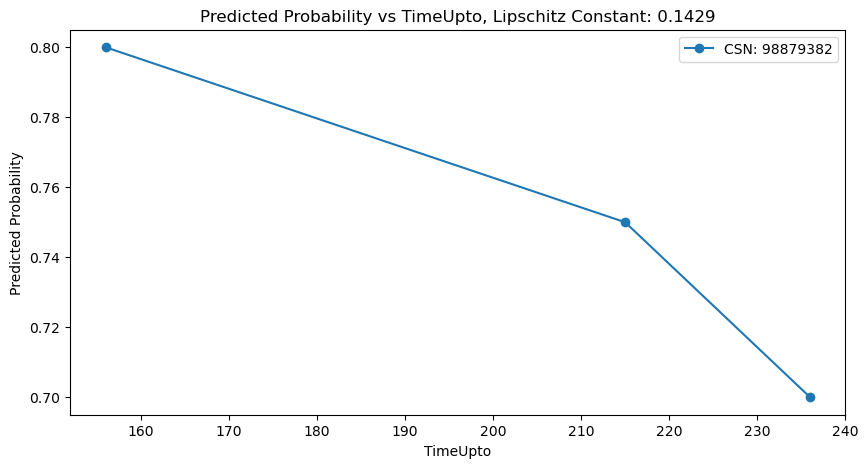

CSN: 98879785, Lipschitz Constant: 6.0000
Max times for Lipschitz constant: 74.0 75.0


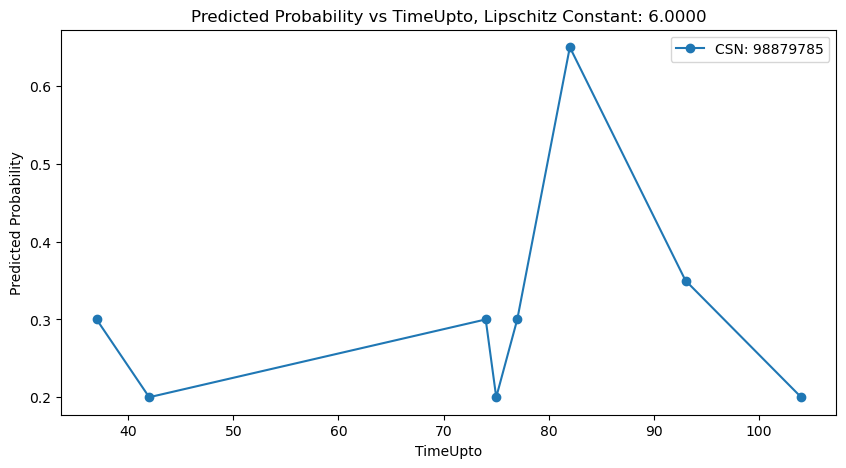

CSN: 98881564, Lipschitz Constant: 2.3333
Max times for Lipschitz constant: 124.0 133.0


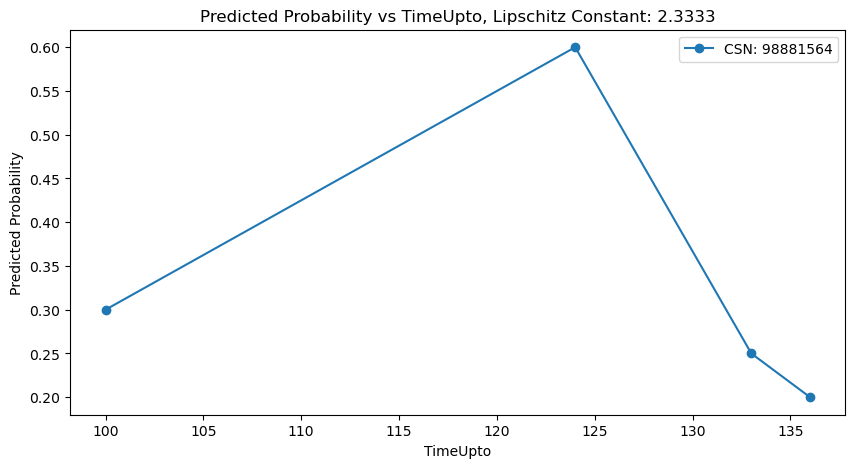

CSN: 98883420, Lipschitz Constant: 3.0000
Max times for Lipschitz constant: 251.0 252.0


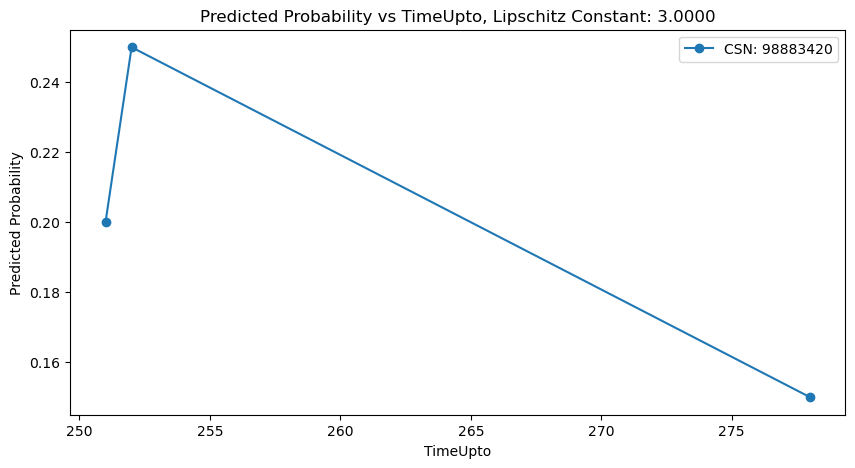

CSN: 98890944, Lipschitz Constant: 12.0000
Max times for Lipschitz constant: 122.0 124.0


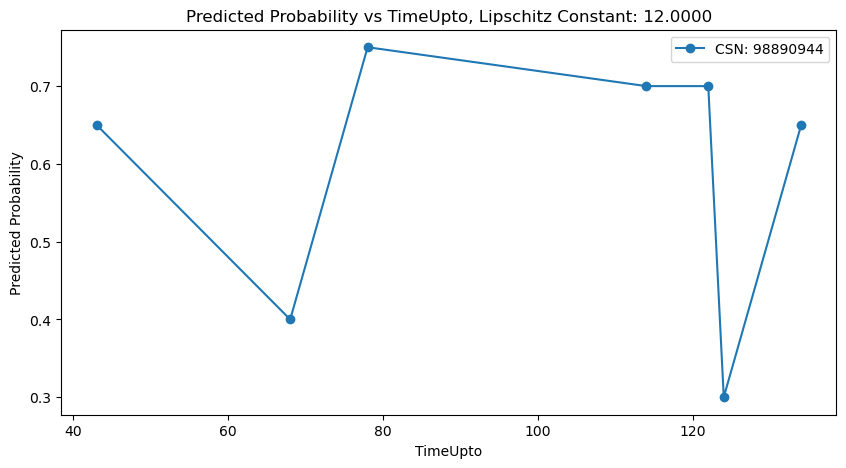

CSN: 98892066, Lipschitz Constant: 6.0000
Max times for Lipschitz constant: 5.0 6.0


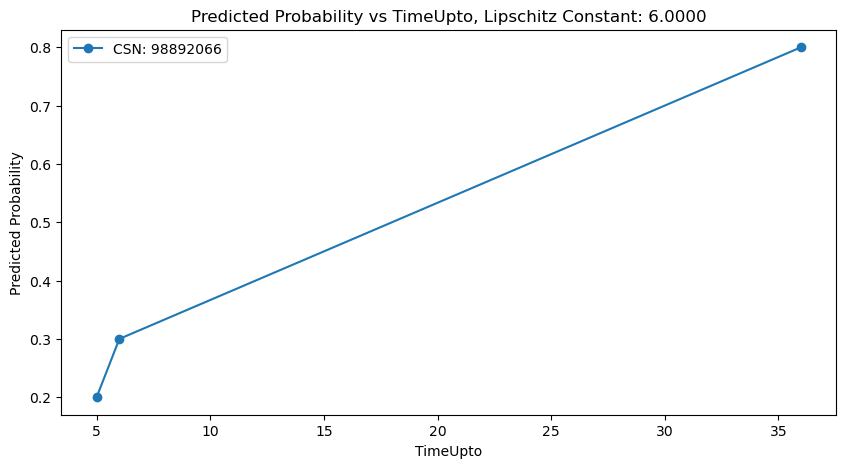

CSN: 98893650, Lipschitz Constant: 1.5000
Max times for Lipschitz constant: 98.0 102.0


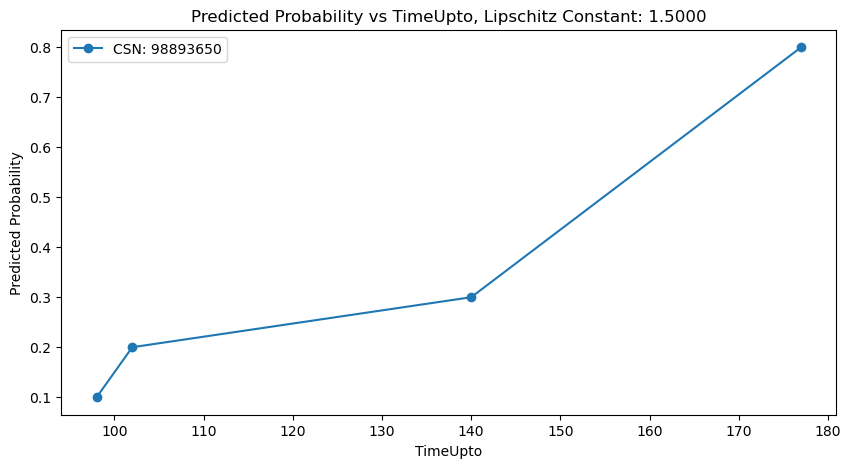

CSN: 98893657, Lipschitz Constant: 0.7500
Max times for Lipschitz constant: 110.0 114.0


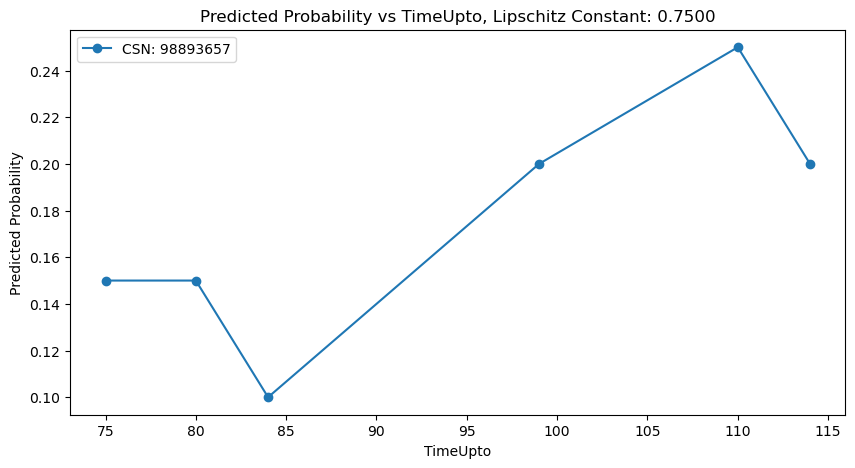

CSN: 98894000, Lipschitz Constant: 24.0000
Max times for Lipschitz constant: 92.0 93.0


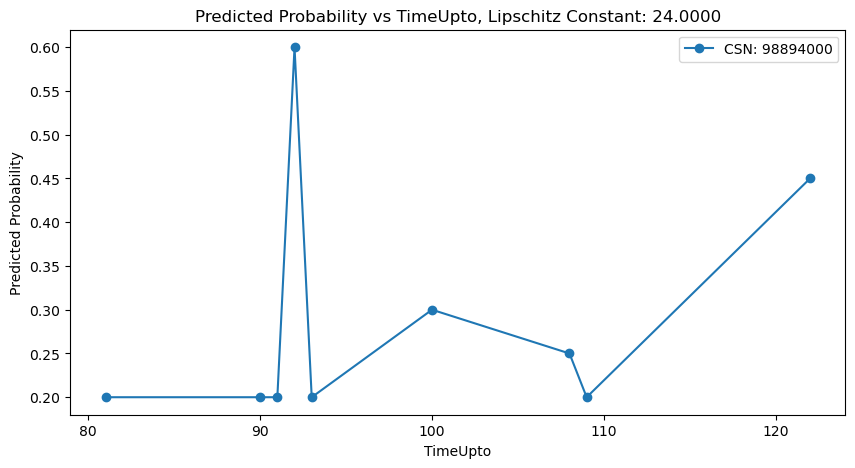

CSN: 98894300, Lipschitz Constant: 3.0000
Max times for Lipschitz constant: 271.0 272.0


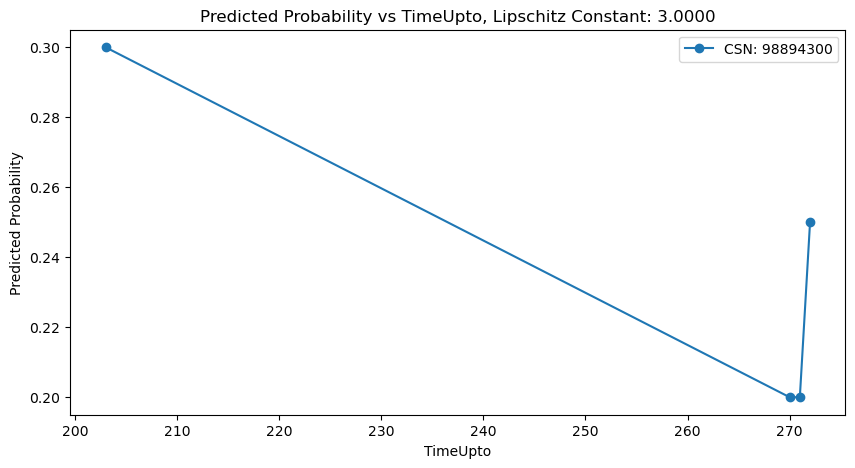

CSN: 98899676, Lipschitz Constant: 3.0000
Max times for Lipschitz constant: 163.0 172.0


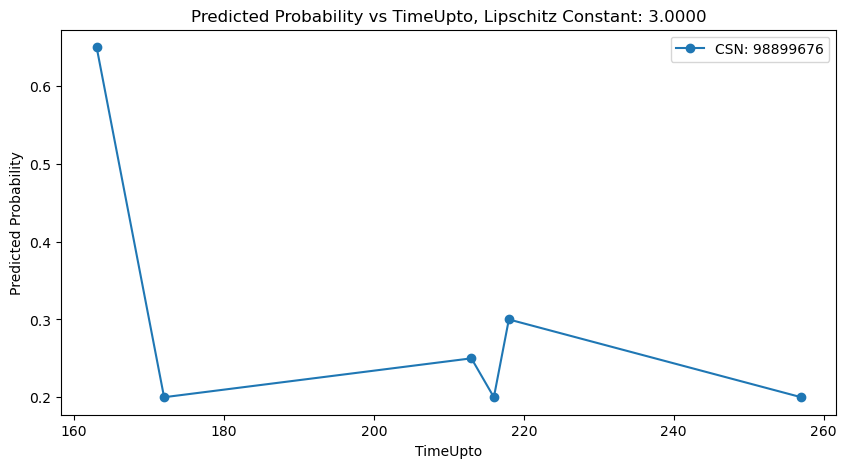

CSN: 98905585, Lipschitz Constant: 27.0000
Max times for Lipschitz constant: 125.0 126.0


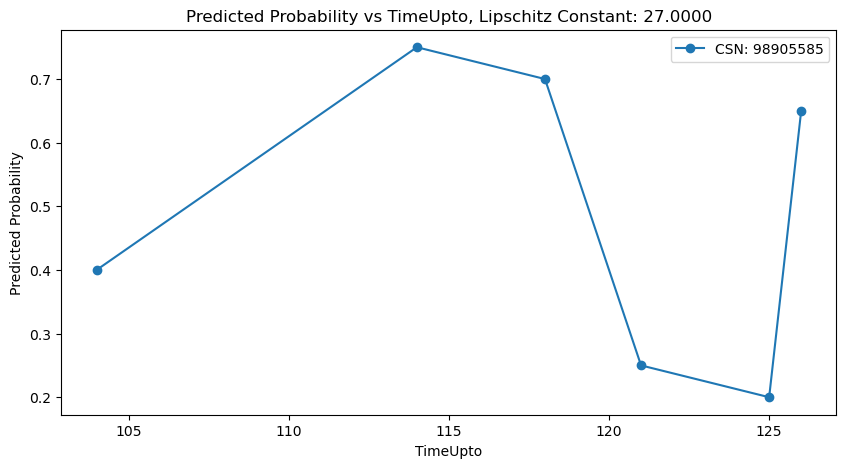

CSN: 98908261, Lipschitz Constant: 3.0000
Max times for Lipschitz constant: 11.0 14.0


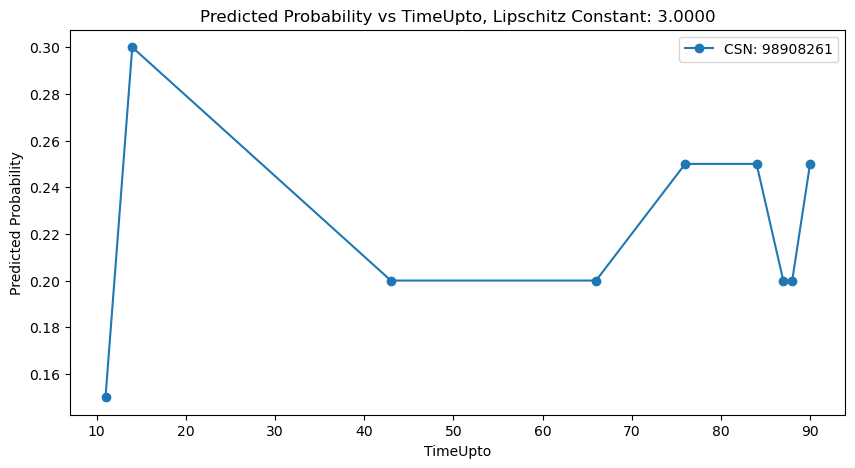

CSN: 98908323, Lipschitz Constant: 3.7500
Max times for Lipschitz constant: 120.0 124.0


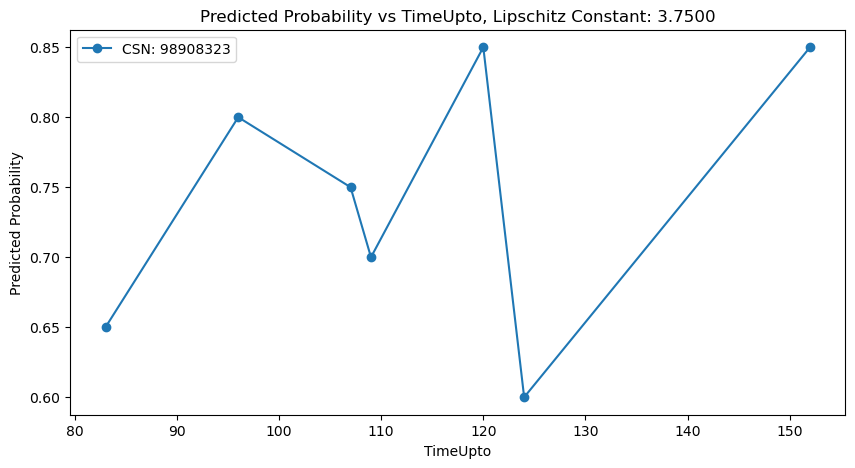

CSN: 98913272, Lipschitz Constant: 1.2000
Max times for Lipschitz constant: 101.0 102.0


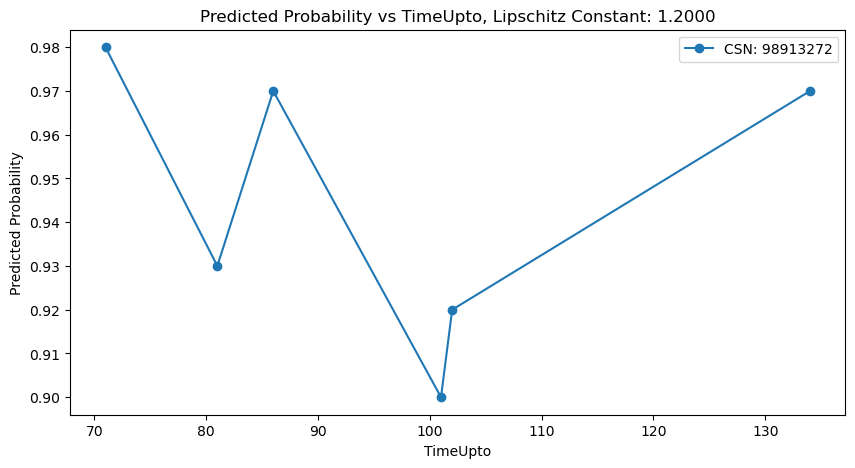

CSN: 98913276, Lipschitz Constant: 0.2308
Max times for Lipschitz constant: 72.0 98.0


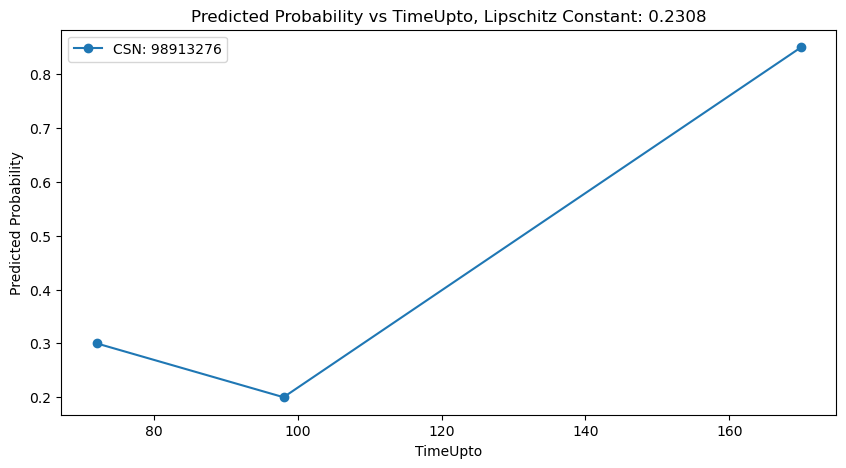

CSN: 98914264, Lipschitz Constant: 0.7895
Max times for Lipschitz constant: 131.0 150.0


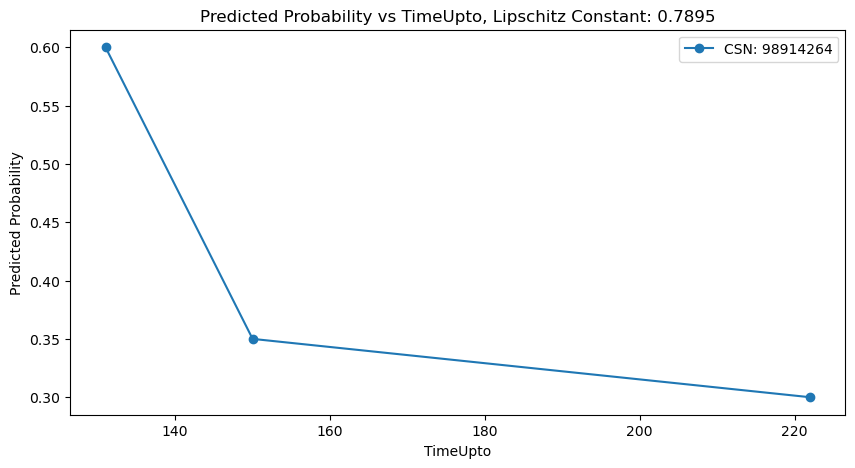

CSN: 98915075, Lipschitz Constant: 1.0000
Max times for Lipschitz constant: 83.0 89.0


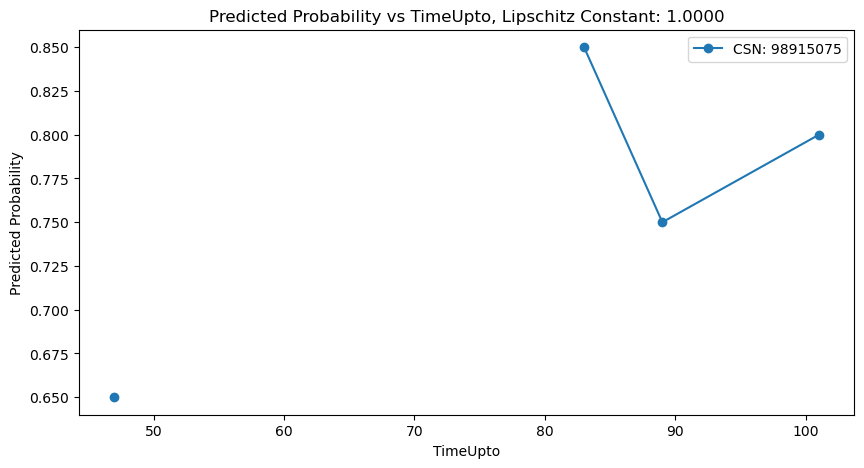

CSN: 98923218, Lipschitz Constant: 24.0000
Max times for Lipschitz constant: 331.0 332.0


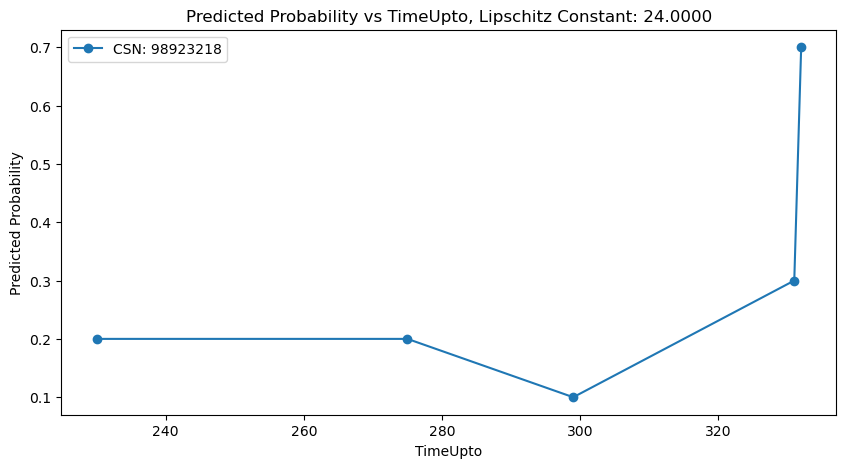

CSN: 98928749, Lipschitz Constant: 3.0000
Max times for Lipschitz constant: 90.0 91.0


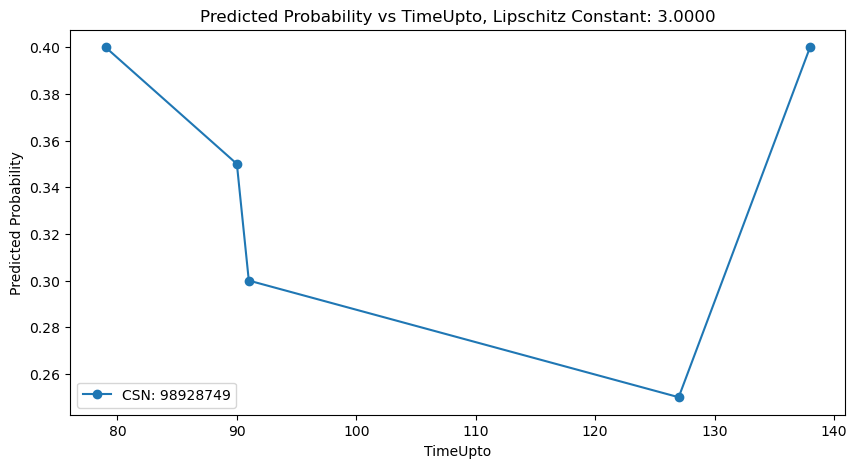

CSN: 98930211, Lipschitz Constant: 4.8000
Max times for Lipschitz constant: 40.0 45.0


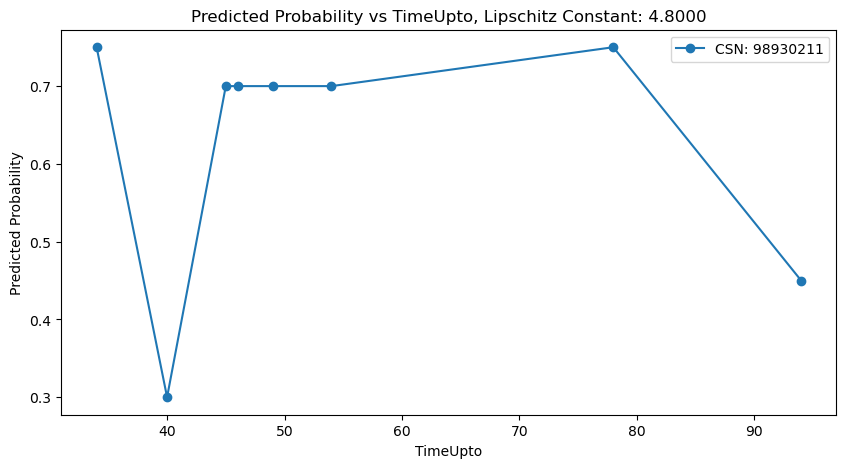

CSN: 98931838, Lipschitz Constant: 1.8462
Max times for Lipschitz constant: 228.0 241.0


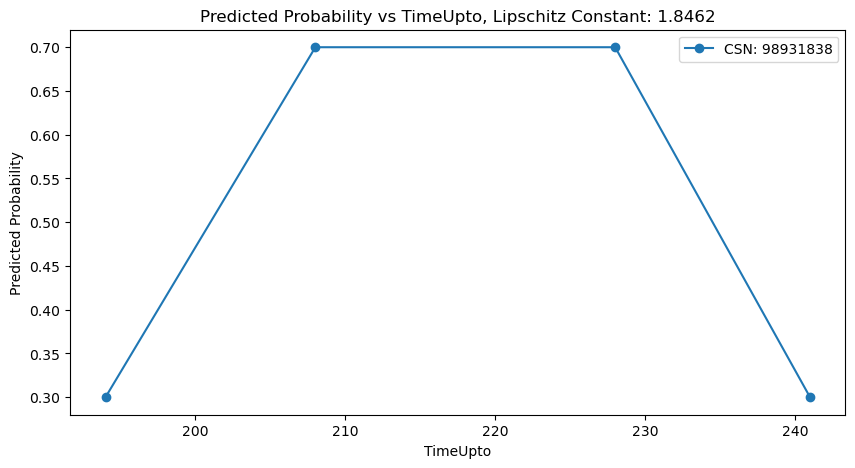

CSN: 98936047, Lipschitz Constant: 0.0000
Max times for Lipschitz constant: 122.0 133.0


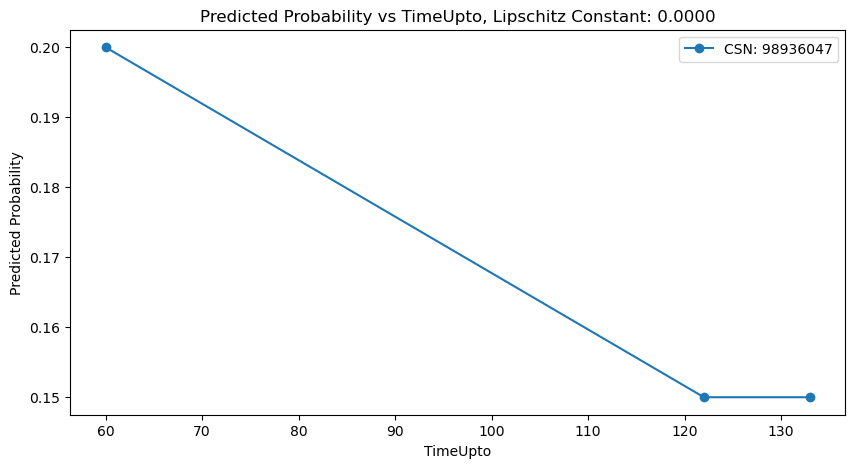

CSN: 98938614, Lipschitz Constant: 0.2143
Max times for Lipschitz constant: 95.0 109.0


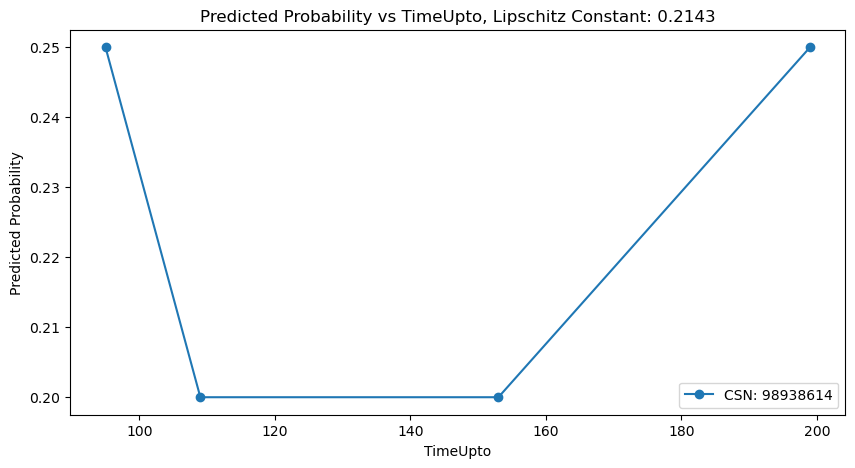

CSN: 98941309, Lipschitz Constant: 0.3000
Max times for Lipschitz constant: 139.0 153.0


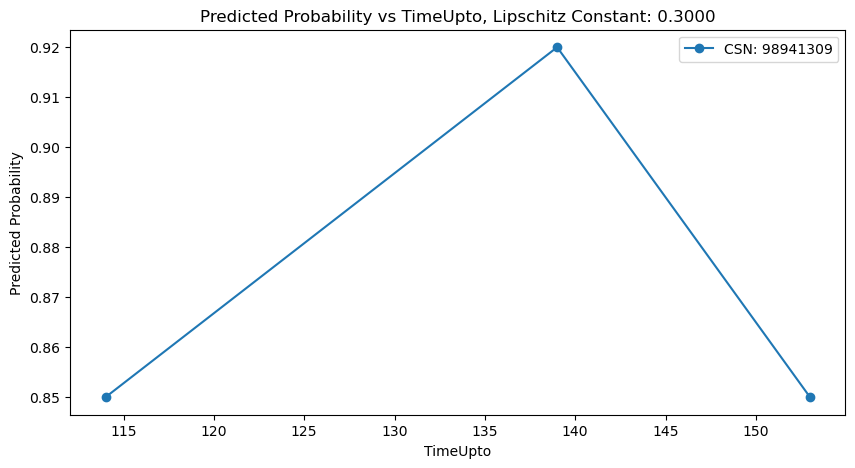

CSN: 98942091, Lipschitz Constant: 1.5000
Max times for Lipschitz constant: 280.0 282.0


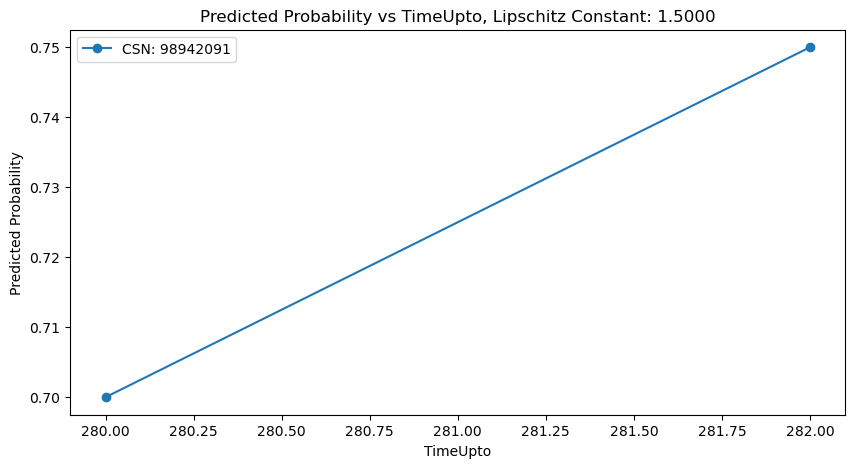

CSN: 98945795, Lipschitz Constant: 4.1250
Max times for Lipschitz constant: 105.0 113.0


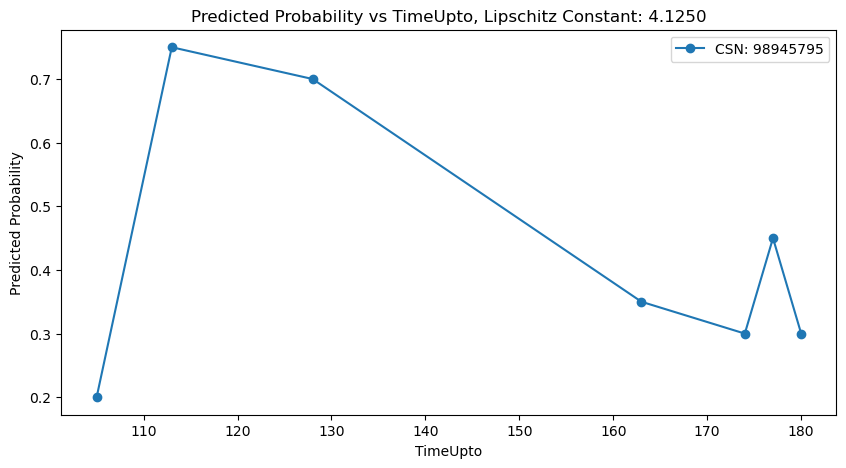

CSN: 98946626, Lipschitz Constant: 39.0000
Max times for Lipschitz constant: 74.0 75.0


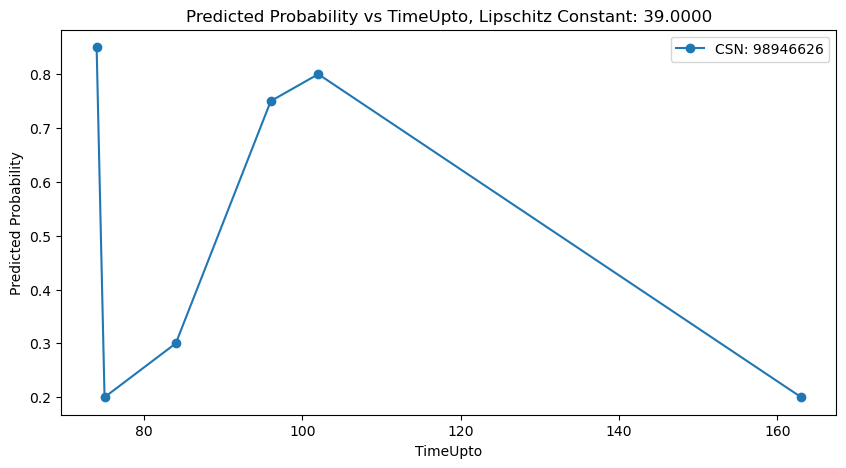

CSN: 98947312, Lipschitz Constant: 0.0000
Max times for Lipschitz constant: 236.0 265.0


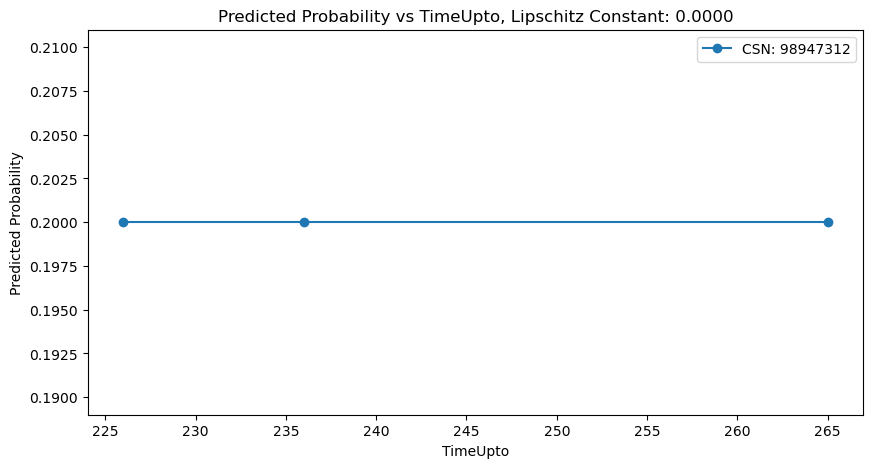

CSN: 98948848, Lipschitz Constant: 13.0000
Max times for Lipschitz constant: 89.0 92.0


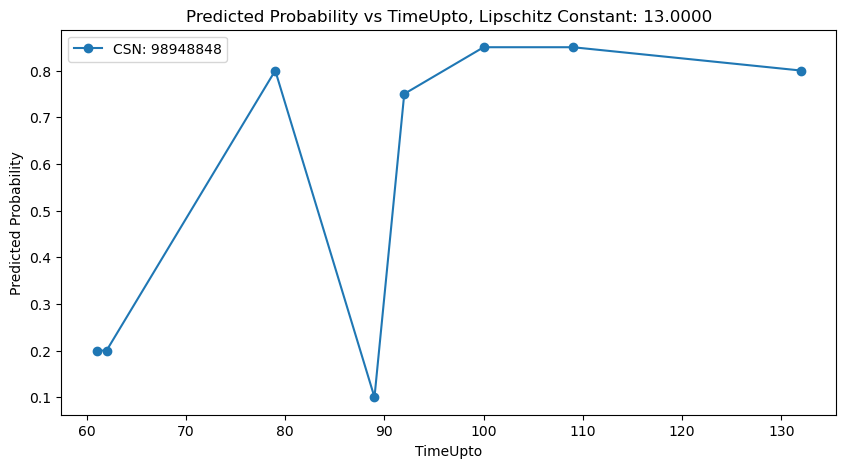

CSN: 98948863, Lipschitz Constant: 0.2143
Max times for Lipschitz constant: 78.0 92.0


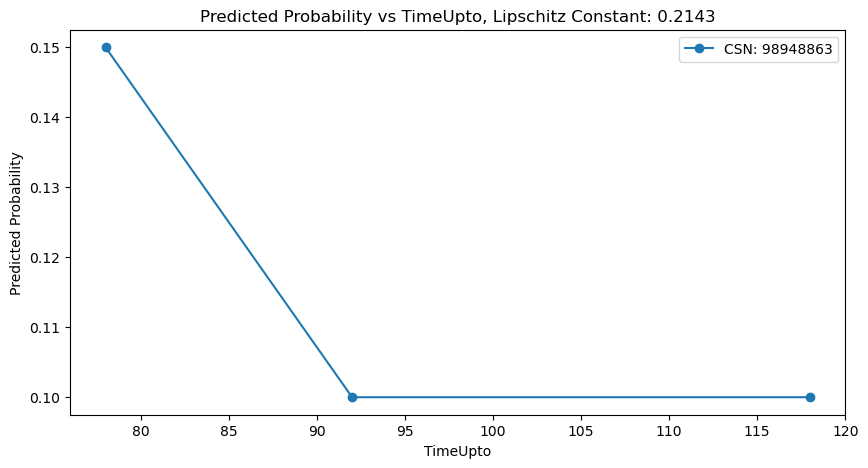

CSN: 98955576, Lipschitz Constant: 0.5000
Max times for Lipschitz constant: 115.0 121.0


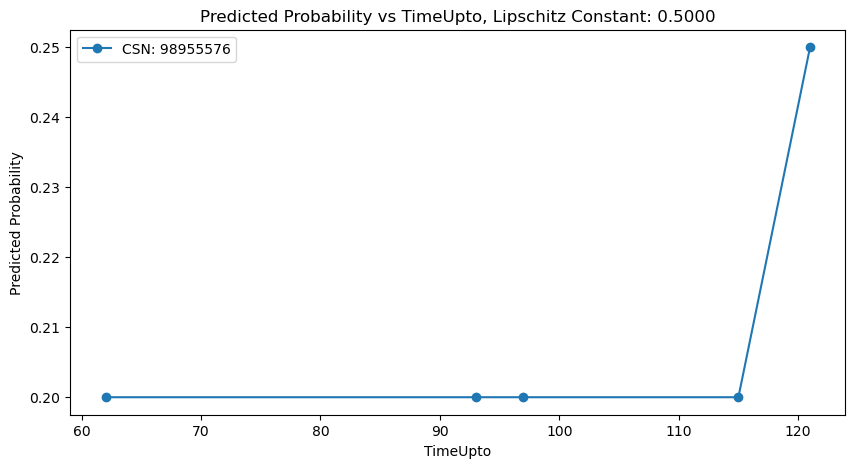

CSN: 98960907, Lipschitz Constant: 18.0000
Max times for Lipschitz constant: 99.0 100.0


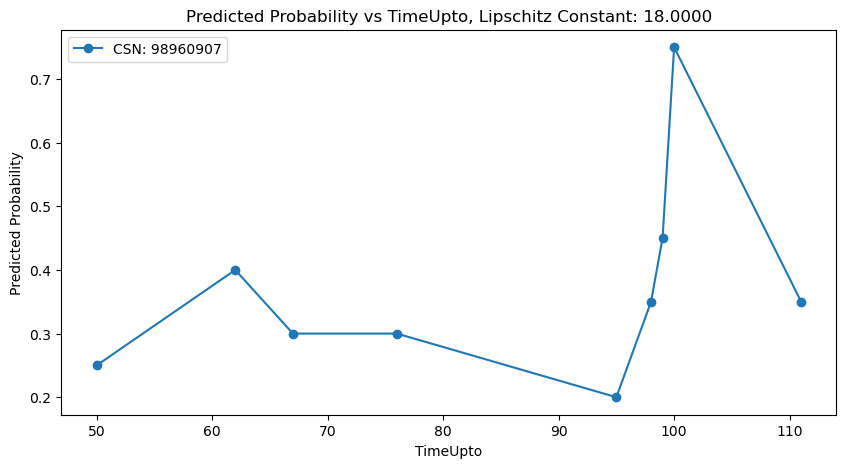

CSN: 98962344, Lipschitz Constant: 0.1463
Max times for Lipschitz constant: 92.0 133.0


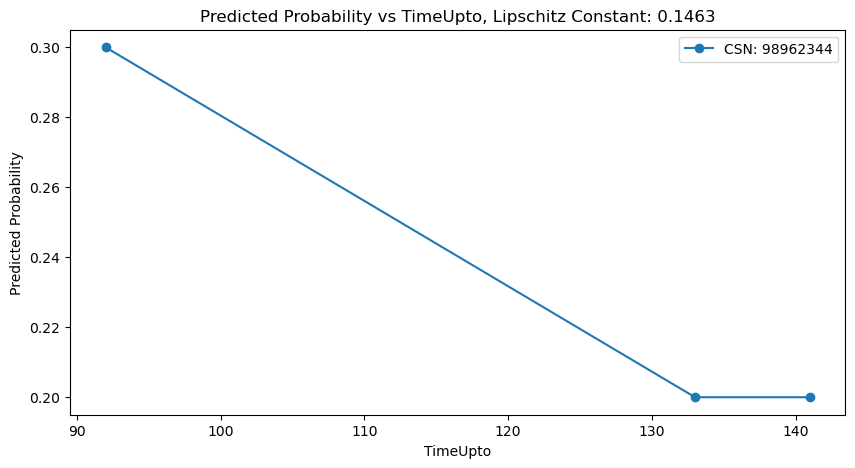

CSN: 98963381, Lipschitz Constant: 0.6316
Max times for Lipschitz constant: 187.0 206.0


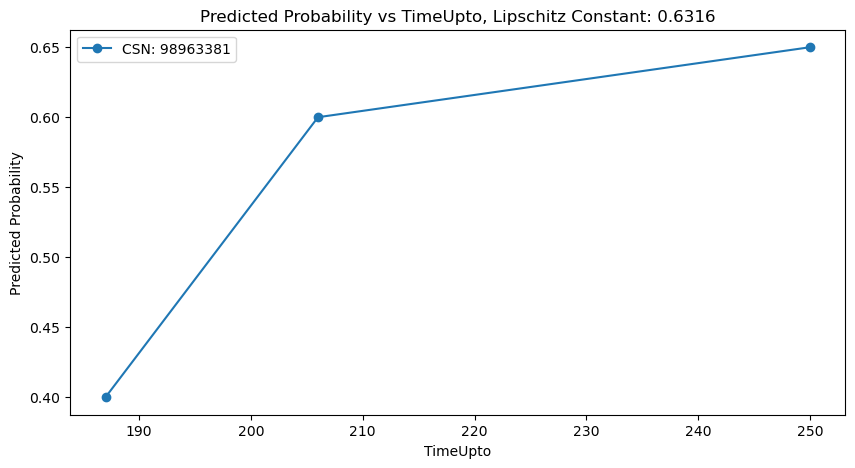

CSN: 98965089, Lipschitz Constant: 27.0000
Max times for Lipschitz constant: 49.0 50.0


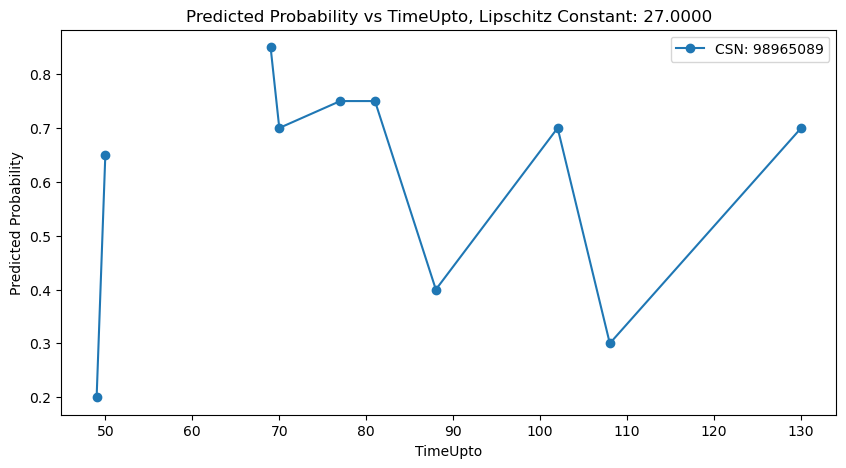

CSN: 98965882, Lipschitz Constant: 3.0000
Max times for Lipschitz constant: 333.0 335.0


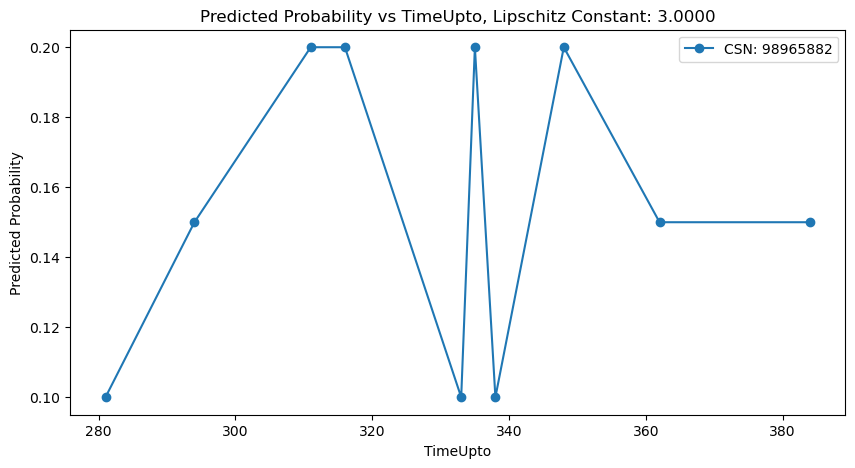

CSN: 98966938, Lipschitz Constant: 0.0000
Max times for Lipschitz constant: 88.0 90.0


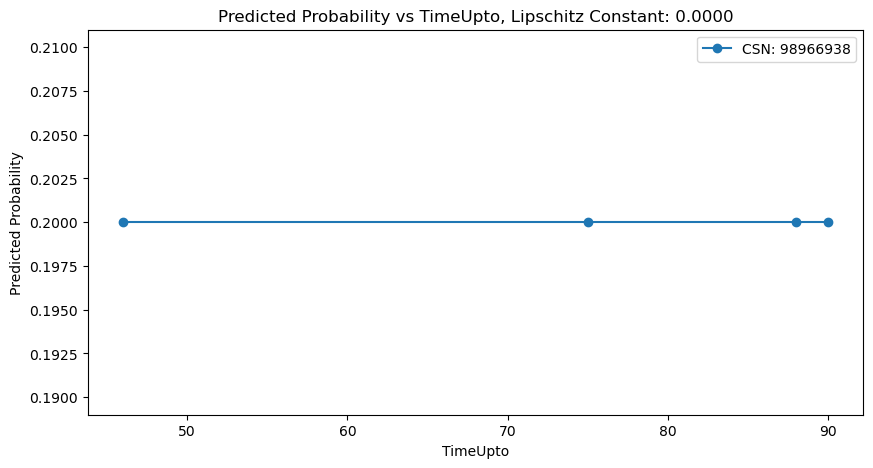

CSN: 98968692, Lipschitz Constant: 10.5000
Max times for Lipschitz constant: 132.0 134.0


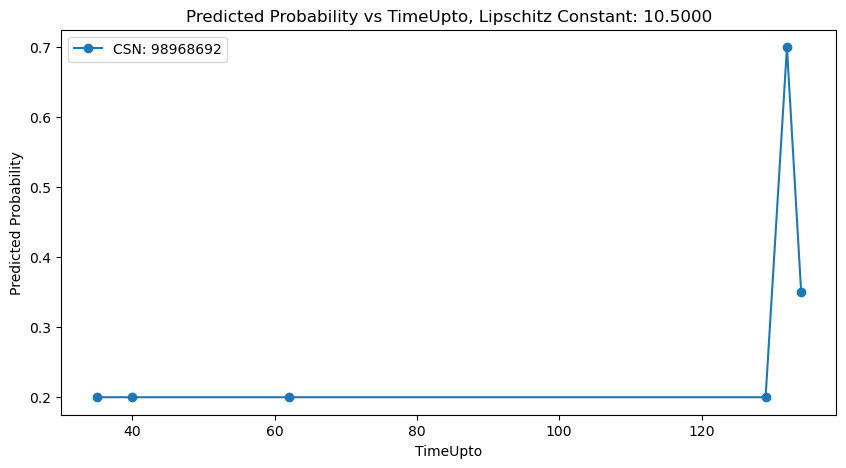

CSN: 98970284, Lipschitz Constant: 0.1875
Max times for Lipschitz constant: 272.0 320.0


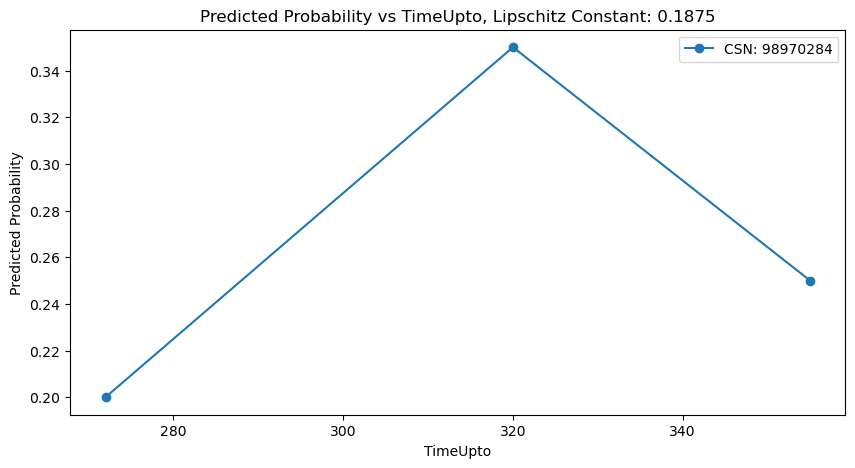

CSN: 98970706, Lipschitz Constant: 1.0000
Max times for Lipschitz constant: 107.0 113.0


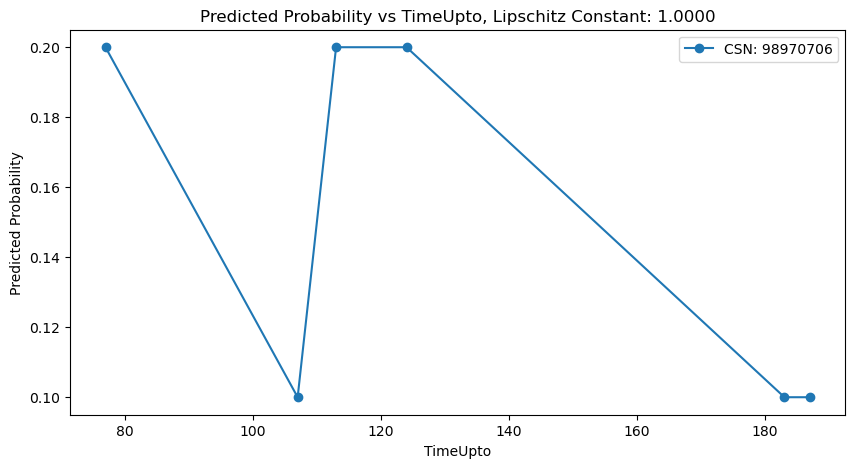

CSN: 98971905, Lipschitz Constant: 1.5000
Max times for Lipschitz constant: 67.0 77.0


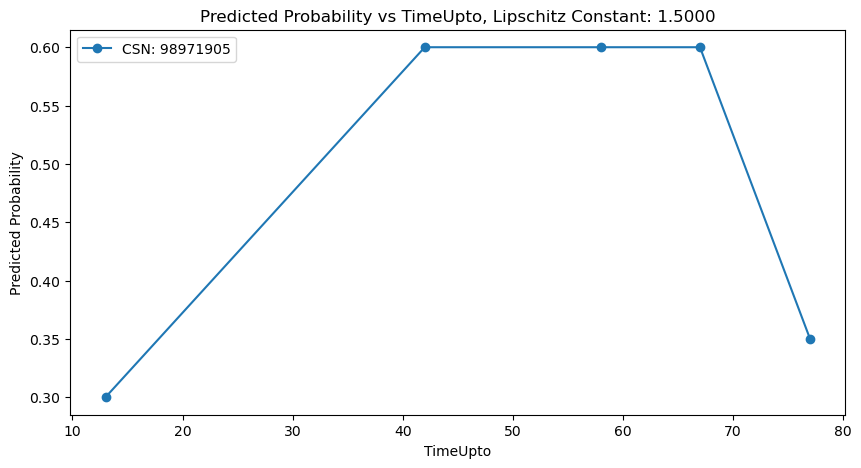

CSN: 98972653, Lipschitz Constant: 0.6000
Max times for Lipschitz constant: 100.0 105.0


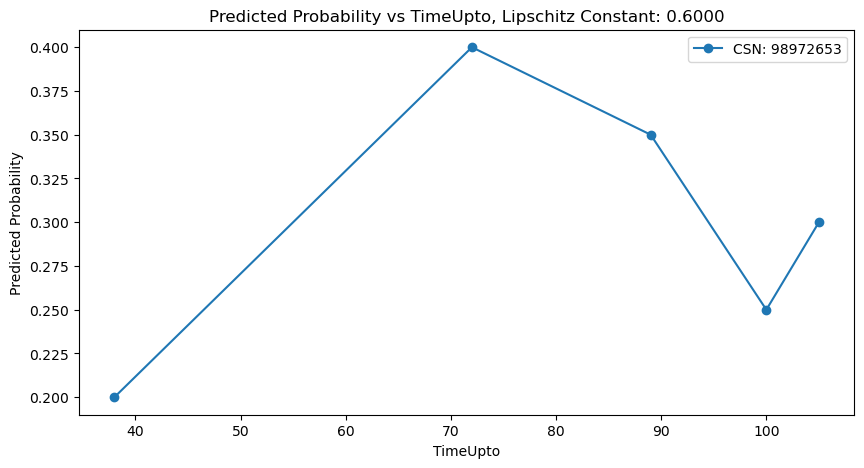

CSN: 98972732, Lipschitz Constant: 37.2000
Max times for Lipschitz constant: 159.0 160.0


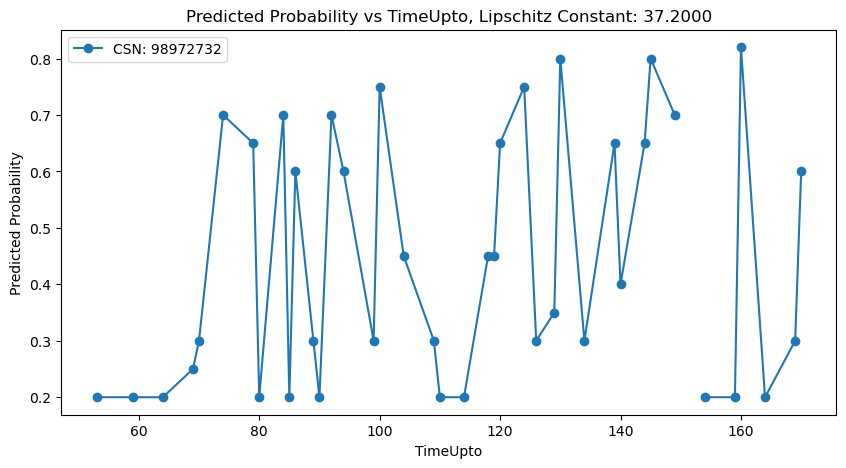

CSN: 98972855, Lipschitz Constant: 0.2368
Max times for Lipschitz constant: 35.0 73.0


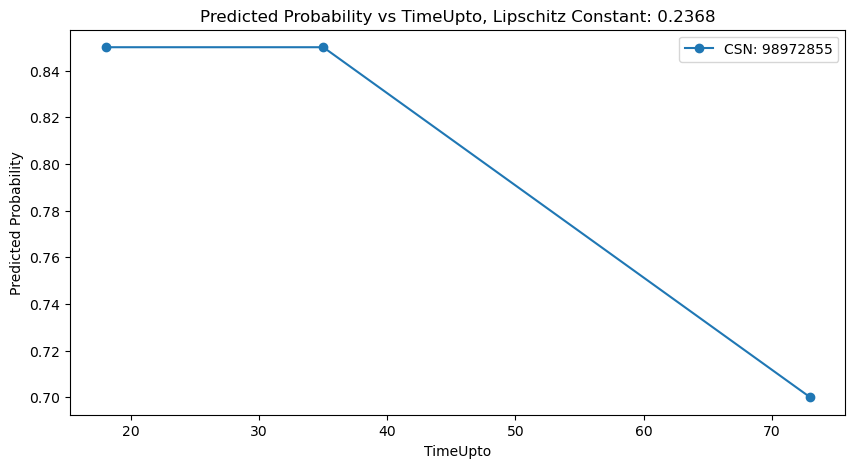

CSN: 98972981, Lipschitz Constant: 33.0000
Max times for Lipschitz constant: 25.0 26.0


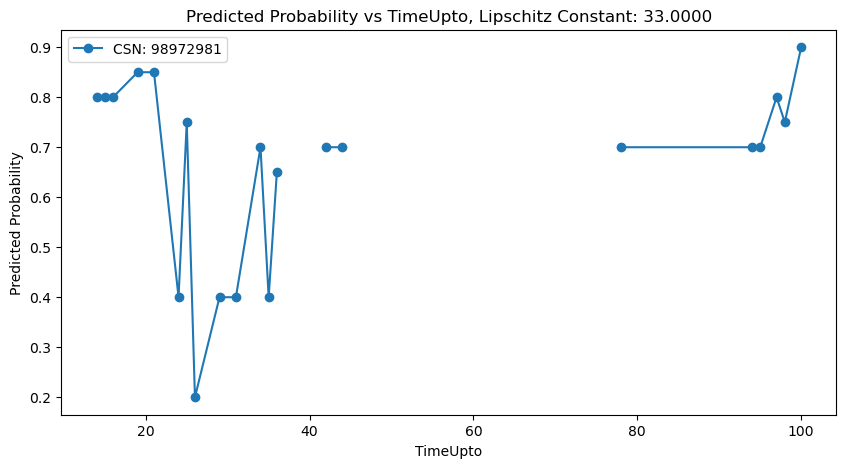

CSN: 98973065, Lipschitz Constant: 0.9000
Max times for Lipschitz constant: 99.0 129.0


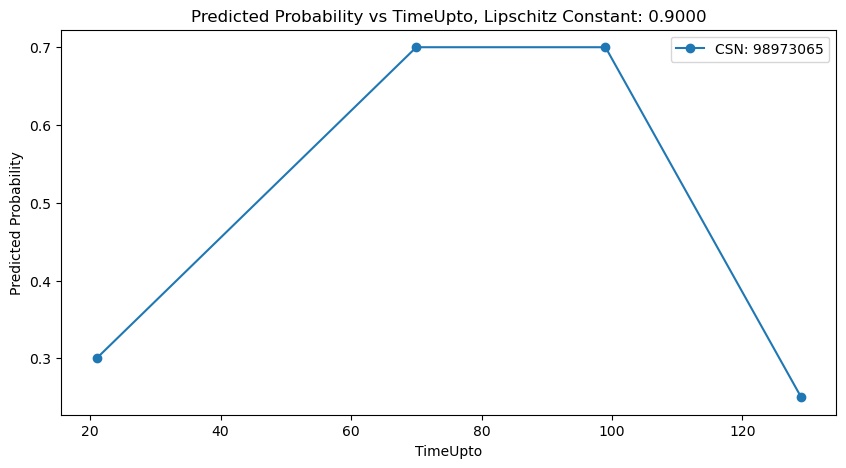

CSN: 98973149, Lipschitz Constant: 21.0000
Max times for Lipschitz constant: 26.0 27.0


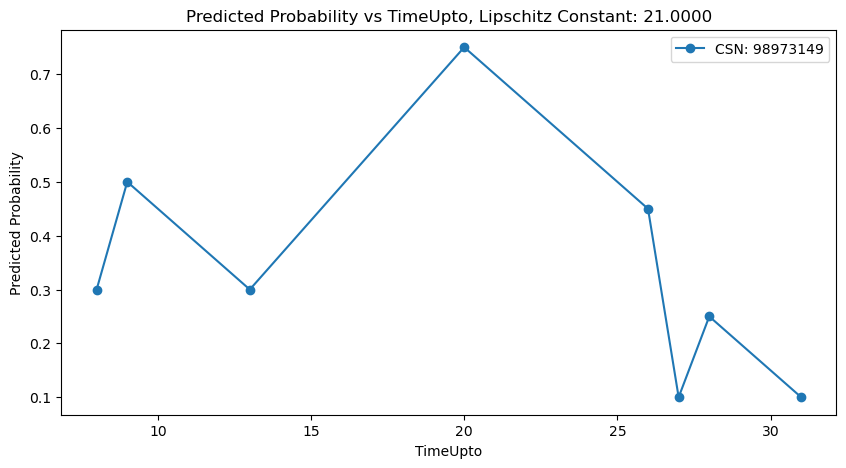

Average Lipschitz Constant over all CSNs: 7.1409


In [ ]:
# compute the lipschitz constant for each CSN, following the paper
# To evaluate stability, we vary the length of the input data and produce multiple risk scores over time. 


# For example, assume we vary the input length $N_i \in \{10, \dots, 20\}$ for input $x_{[1 \dots N]}$ and set the local window $c = 2$. 

# We first train the model on each $N_i$ and obtain risk scores $y_1, \dots y_{10} \in [0, 1]$.
# We consider the risk score $y_i$ to be a function of the final timestamp $t_{N_i}$ and compute Lipschitz constant for every window of size $c$. 
# We take the maximum of such constant as the stability score $L_c$:
# \[L_c = \sup_{\substack{||t - t'|| \leq c \\ t\neq t'}} \frac{\|f(t) - f(t')\|}{\|t - t'\|}\]
# where $f(t)$ is the risk score at time $t$.

def compute_lipschitz_constant(entries, c=60):
    # Sort entries by TimeUpto
    entries.sort(key=lambda x: x["TimeUpto"])
    
    # Extract times and predicted probabilities
    times = [entry["TimeUpto"] for entry in entries]
    probs = [entry["PredictedProb"] for entry in entries]
    
    # Initialize max_lipschitz constant
    max_lipschitz_constant = 0.0
    max_t1 = 0
    max_t2 = 0
    
    # Compute Lipschitz constant for each pair of times where the difference is less than c
    # We will use a sliding window approach to compute the Lipschitz constant
    for i in range(len(times)):
        for j in range(i + 1, len(times)):
            if probs[i] is None or probs[j] is None:
                continue
            if abs(times[i] - times[j]) <= c:
                # Compute Lipschitz constant
                delta_prob = abs(probs[i] - probs[j])
                delta_time = abs(times[i] - times[j])
                if delta_time > 0:  # Avoid division by zero
                    lipschitz_constant = (delta_prob / delta_time) * 60 # Scale to hourly measure
                    max_lipschitz_constant = max(max_lipschitz_constant, lipschitz_constant)
                    # Store the times for which the max Lipschitz constant was found
                    if lipschitz_constant == max_lipschitz_constant:
                        max_t1 = times[i]
                        max_t2 = times[j]
    return max_lipschitz_constant, max_t1, max_t2

# Compute Lipschitz constant for each CSN
lipschitz_results = {}
for csn, entries in filtered_grouped_results.items():
    lipschitz_constant, max_t1, max_t2 = compute_lipschitz_constant(entries)
    lipschitz_results[csn] = lipschitz_constant
    print(f"CSN: {csn}, Lipschitz Constant: {lipschitz_constant:.4f}")
    print("Max times for Lipschitz constant:", max_t1, max_t2)
    # plot times vs predicted probabilities along with the Lipschitz constant, mark the points with a circle
    # and also join the points with a line
    import matplotlib.pyplot as plt
    import numpy as np
    times = [entry["TimeUpto"] for entry in entries]
    probs = [entry["PredictedProb"] for entry in entries]
    plt.figure(figsize=(10, 5))
    plt.plot(times, probs, marker='o', linestyle='-', label=f"CSN: {csn}")
    plt.xlabel("TimeUpto")
    plt.ylabel("Predicted Probability")
    plt.title(f"Predicted Probability vs TimeUpto, Lipschitz Constant: {lipschitz_constant:.4f}")
    plt.legend()
    plt.show()

# average the Lipschitz constant over all CSNs
average_lipschitz_constant = sum(lipschitz_results.values()) / len(lipschitz_results)
print(f"Average Lipschitz Constant over all CSNs: {average_lipschitz_constant:.4f}")
